## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy.spatial.distance import cdist
from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, PolynomialFeatures
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = "png"
np.random.seed(42)

In [2]:
train_df = pd.read_csv("course_project_train.csv")

In [3]:
train_df.head()

Home Ownership  Annual Income Years in current job  Tax Liens  \
0       Own Home       482087.0                  NaN        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   
3       Own Home       805068.0              6 years        0.0   
4           Rent       776264.0              8 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        1.0                           NaN           1.0   
1                        0.0                           NaN           0.0   
2                        0.0                           NaN           0.0   
3                        1.0                           NaN           1.0   
4                        1.0                           NaN           0.0   

              Purpose        Term  Current Loan Amount  \
0  debt consolidation  Short Term           99999999.0   
1  debt consolidation   Long Term             264968.0   
2  debt consolidation  Short Term           99999999.0   
3  debt consolidation  Short Term             121396.0   
4  debt consolidation  Short Term             125840.0   

   Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
0                 47386.0        7914.0         749.0               0  
1                394972.0       18373.0         737.0               1  
2                308389.0       13651.0         742.0               0  
3                 95855.0       11338.0         694.0               0  
4                 93309.0        7180.0         719.0               0

In [4]:
train_df.shape

(7500, 17)

In [5]:
test_df = pd.read_csv("course_project_test.csv")

In [6]:
test_df.head()

Home Ownership  Annual Income Years in current job  Tax Liens  \
0           Rent            NaN              4 years        0.0   
1           Rent       231838.0               1 year        0.0   
2  Home Mortgage      1152540.0              3 years        0.0   
3  Home Mortgage      1220313.0            10+ years        0.0   
4  Home Mortgage      2340952.0              6 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                      9.0                     12.5             220968.0   
1                      6.0                     32.7              55946.0   
2                     10.0                     13.7             204600.0   
3                     16.0                     17.0             456302.0   
4                     11.0                     23.6            1207272.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        0.0                          70.0           0.0   
1                        0.0                           8.0           0.0   
2                        0.0                           NaN           0.0   
3                        0.0                          70.0           0.0   
4                        0.0                           NaN           0.0   

                Purpose        Term  Current Loan Amount  \
0    debt consolidation  Short Term             162470.0   
1  educational expenses  Short Term              78298.0   
2    debt consolidation  Short Term             200178.0   
3    debt consolidation  Short Term             217382.0   
4    debt consolidation   Long Term             777634.0   

   Current Credit Balance  Monthly Debt  Credit Score  
0                105906.0        6813.0           NaN  
1                 46037.0        2318.0         699.0  
2                146490.0       18729.0        7260.0  
3                213199.0       27559.0         739.0  
4                425391.0       42605.0         706.0

In [7]:
test_df.shape

(2500, 16)

In [8]:
train_df.shape[1]-1 == test_df.shape[1]

True

### Уменьшим размер данных в памяти и приведём их к единому типу

In [9]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [10]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%
Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.13 MB
Decreased by 58.9%


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7129 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  3419 non-null   float32 
 9   Bankruptcies                  7486 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

# EDA

* поиск и исправление выбросов
* поиск и заполнение пропусков
* идеи для генерации новых признаков

### Целевая переменная

In [12]:
y = train_df['Credit Default']
y.value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [13]:
def display_clusters_distribution(df):
    unique = df.value_counts().index.tolist()
    counts = df.value_counts().values.tolist()
        
    """Визуализация распределения классов по кластерам"""
    #plt.figure(figsize=(8,5))

    plt.bar(unique, counts)

    plt.xlabel('Clusters')
    plt.xticks(unique)
    plt.ylabel('Count')
    plt.title('Clusters distribution')
    plt.xticks(rotation=45)
    plt.show()

In [14]:
def boxplot(df, y, feature):
    sns.set(rc={'figure.figsize':(20,10)})
    plt.xticks(rotation=45)
    sns.boxplot(df[feature], y)
    plt.show()
    plt.close()

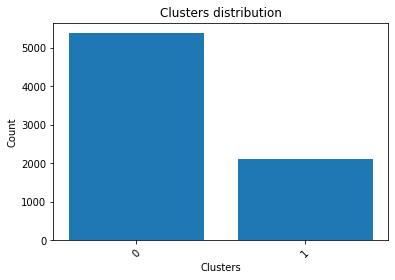

In [15]:
display_clusters_distribution(y)

### Целевая переменная несбалансирована, нужно будет попробовать расширить набор данных, например оверсемплингом

## Посмотрим категориальные данные

Признак: Home Ownership


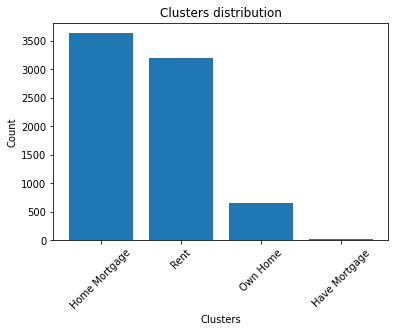

Признак: Years in current job


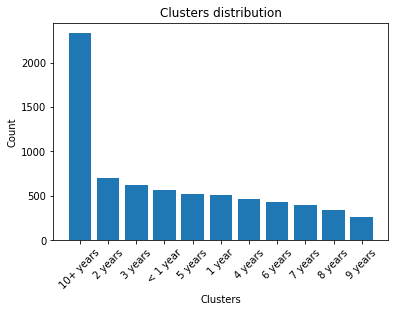

Признак: Purpose


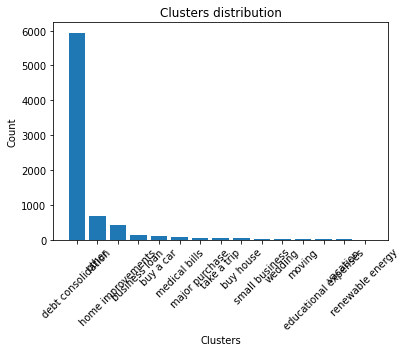

Признак: Term


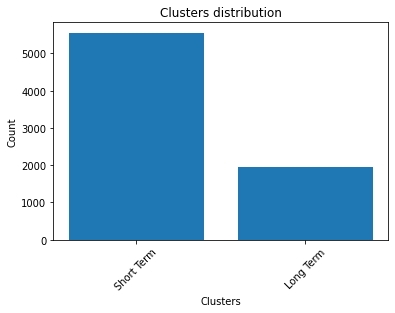

In [16]:
categories = train_df.select_dtypes(include="category").columns.tolist()
numerical = train_df.select_dtypes(exclude="category").columns.tolist()

for feature in categories:
    print(f"Признак: {feature}")
    display_clusters_distribution(train_df[feature])
    

### С признаками всё в порядке, один Purpose излишне несбалансирован, возможно стоит выразить его через свою численность

## Посмотрим числовые данные

In [17]:
def deviations(series):
  median = series.quantile(q=0.5)
  avg = series.mean()
  std = series.std()
  mode = series.mode()[0]
  print(f"Медиана со средним значением отличаются на {round(abs(median-avg)/std, 2):.02f} стандартных отклонения")
  if series.min() < median-std*3:
    print(f"Минимальное значение меньше, чем медиана - 3 стандартных отклонения (выходит из 99,7% диапазона данных)")
  if series.max() > median+std*3:
    print(f"Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)")
  return median, avg, mode

In [18]:
def hist_plot(df, feature, median, avg, mode):
    #sns.set(rc={'figure.figsize':(20,10)})
    sns.distplot(df[feature])
    plt.axvline(median, c="red", label="median")
    plt.axvline(avg, c="green", label="average")
    plt.axvline(mode, c="orange", label="mode")
    plt.legend(loc="best", frameon=False)
    plt.title(feature)
    fig = plt.figure()
    #res = stats.probplot(df[feature], plot=plt)
    plt.show()
    plt.close()

Признак: Annual Income
count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64
1043651.0    4
1161660.0    4
1338113.0    4
969475.0     4
1058376.0    4
            ..
2185646.0    1
2326075.0    1
330429.0     1
1704965.0    1
648166.0     1
Name: Annual Income, Length: 5478, dtype: int64
Медиана со средним значением отличаются на 0.23 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


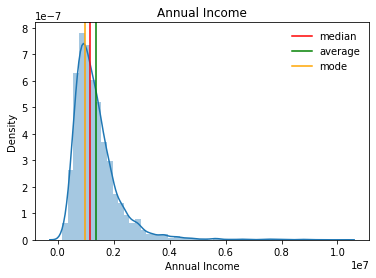

<Figure size 432x288 with 0 Axes>

Признак: Tax Liens
count    7500.000000
mean        0.030133
std         0.271604
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: Tax Liens, dtype: float64
0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64
Медиана со средним значением отличаются на 0.11 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


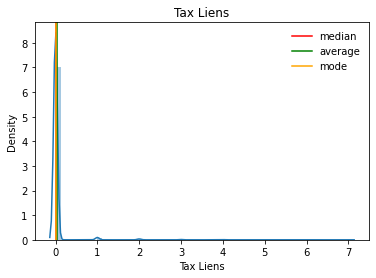

<Figure size 432x288 with 0 Axes>

Признак: Number of Open Accounts
count    7500.000000
mean       11.130934
std         4.908924
min         2.000000
25%         8.000000
50%        10.000000
75%        14.000000
max        43.000000
Name: Number of Open Accounts, dtype: float64
9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
33.0      6
31.0      6
32.0      6
34.0      2
37.0      2
42.0      1
43.0      1
35.0      1
38.0      1
41.0      1
Name: Number of Open Accounts, dtype: int64
Медиана со средним значением отличаются на 0.23 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


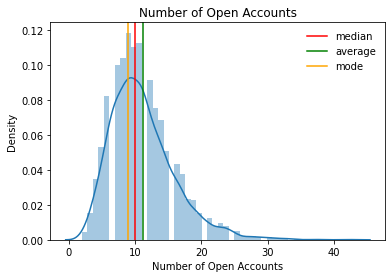

<Figure size 432x288 with 0 Axes>

Признак: Years of Credit History
count    7500.000000
mean       18.317467
std         7.041946
min         4.000000
25%        13.500000
50%        17.000000
75%        21.799999
max        57.700001
Name: Years of Credit History, dtype: float64
15.000000    104
16.000000     99
16.500000     91
17.000000     86
17.500000     83
            ... 
44.000000      1
42.299999      1
36.700001      1
49.099998      1
44.799999      1
Name: Years of Credit History, Length: 408, dtype: int64
Медиана со средним значением отличаются на 0.19 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


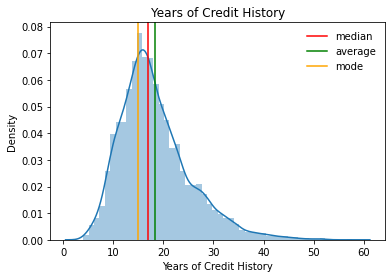

<Figure size 432x288 with 0 Axes>

Признак: Maximum Open Credit
count    7.500000e+03
mean     9.451538e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64
0.0          65
319110.0      5
334796.0      3
358732.0      3
323312.0      3
             ..
235642.0      1
1435456.0     1
397078.0      1
537680.0      1
1516482.0     1
Name: Maximum Open Credit, Length: 6963, dtype: int64
Медиана со средним значением отличаются на 0.03 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


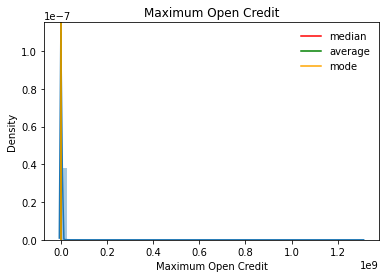

<Figure size 432x288 with 0 Axes>

Признак: Number of Credit Problems
count    7500.000000
mean        0.170000
std         0.498598
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: Number of Credit Problems, dtype: float64
0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64
Медиана со средним значением отличаются на 0.34 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


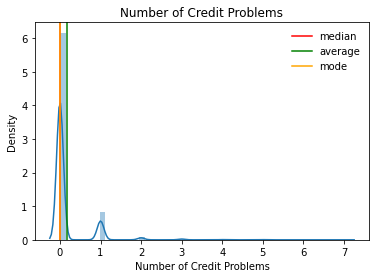

<Figure size 432x288 with 0 Axes>

Признак: Months since last delinquent
count    3419.000000
mean       34.692600
std        21.688807
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64
14.0     76
29.0     71
33.0     68
8.0      68
19.0     65
         ..
84.0      1
86.0      1
91.0      1
118.0     1
92.0      1
Name: Months since last delinquent, Length: 89, dtype: int64
Медиана со средним значением отличаются на 0.12 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


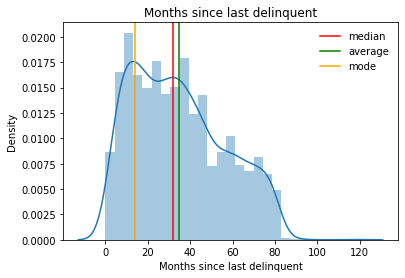

<Figure size 432x288 with 0 Axes>

Признак: Bankruptcies
count    7486.000000
mean        0.117152
std         0.347192
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: Bankruptcies, dtype: float64
0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64
Медиана со средним значением отличаются на 0.34 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


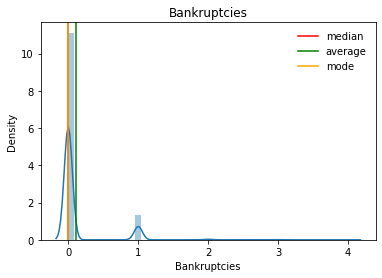

<Figure size 432x288 with 0 Axes>

Признак: Current Loan Amount
count         7500.0
mean      11873178.0
std       31926124.0
min          11242.0
25%         180169.0
50%         309573.0
75%         519882.0
max      100000000.0
Name: Current Loan Amount, dtype: float64
100000000.0    870
89298.0          6
218064.0         6
216106.0         5
265826.0         5
              ... 
222860.0         1
104324.0         1
201080.0         1
427812.0         1
191136.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64
Медиана со средним значением отличаются на 0.36 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


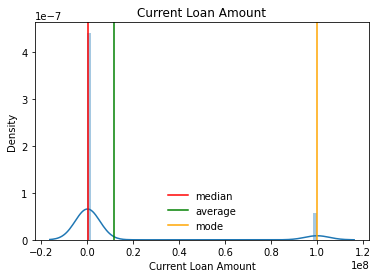

<Figure size 432x288 with 0 Axes>

Признак: Current Credit Balance
count    7.500000e+03
mean     2.898332e+05
std      3.178714e+05
min      0.000000e+00
25%      1.142565e+05
50%      2.093230e+05
75%      3.604062e+05
max      6.506797e+06
Name: Current Credit Balance, dtype: float64
0.0         53
191710.0     5
106818.0     4
136401.0     4
82289.0      4
            ..
64733.0      1
66709.0      1
42199.0      1
871036.0     1
346902.0     1
Name: Current Credit Balance, Length: 6592, dtype: int64
Медиана со средним значением отличаются на 0.25 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


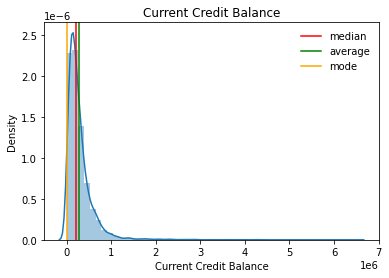

<Figure size 432x288 with 0 Axes>

Признак: Monthly Debt
count      7500.000000
mean      18314.453125
std       11926.764648
min           0.000000
25%       10067.500000
50%       16076.500000
75%       23818.000000
max      136679.000000
Name: Monthly Debt, dtype: float64
0.0        6
19667.0    4
19222.0    4
19277.0    3
9669.0     3
          ..
12857.0    1
10777.0    1
29267.0    1
25050.0    1
31119.0    1
Name: Monthly Debt, Length: 6716, dtype: int64
Медиана со средним значением отличаются на 0.19 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


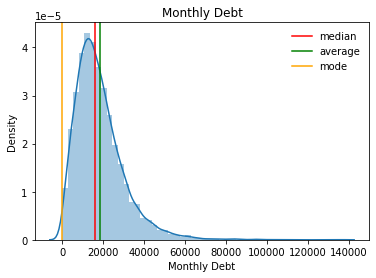

<Figure size 432x288 with 0 Axes>

Признак: Credit Score
count    5943.000000
mean     1151.087524
std      1604.451416
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64
740.0     169
747.0     168
748.0     157
745.0     152
742.0     151
         ... 
629.0       1
606.0       1
6830.0      1
6670.0      1
620.0       1
Name: Credit Score, Length: 268, dtype: int64
Медиана со средним значением отличаются на 0.26 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


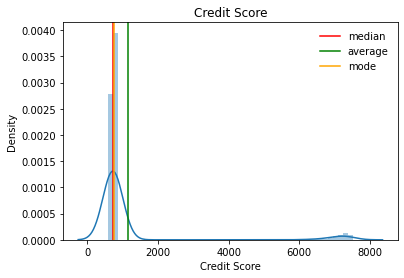

<Figure size 432x288 with 0 Axes>

Признак: Credit Default
count    7500.000000
mean        0.281733
std         0.449874
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Credit Default, dtype: float64
0    5387
1    2113
Name: Credit Default, dtype: int64
Медиана со средним значением отличаются на 0.63 стандартных отклонения


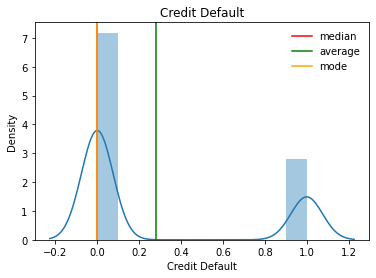

<Figure size 432x288 with 0 Axes>

In [19]:
for feature in numerical:
    print(f"Признак: {feature}")
    print(train_df[feature].describe())
    print(train_df[feature].value_counts())
    median, avg, mode = deviations(train_df[feature])
    hist_plot(train_df, feature, median, avg, mode)
    print("="*80)

### Выводы
* Большинству данных потребуется логарифмическая или ранговая нормализация
* Tax Liens, Number of Credit Problems, Bankruptcies - категориальные признаки (???)
* Очень не нравится в Current Loan Amount значение 100млн. Возможно, выброс.
* Maximum Open Credit, Current Credit Balance, Monthly Debt в 0 тоже маловероятен
* Credit Score максимальный 850, всё что больше нужно делить на 10.

In [20]:
class DataProcessor:
        
#     @staticmethod
#     def change_to_category(df):
#         # Переназначим категориальные признаки
#         suspected_categorials = ["Tax Liens"] # "Tax Liens", "Number of Credit Problems", "Bankruptcies", 
#         for col in suspected_categorials:
#             df[col] = df[col].astype("category")
#         return df
    
    @staticmethod
    def remove_outliers(df):
        # уберём выбросы
        df["Current Loan Amount"].loc[df["Current Loan Amount"] >= 99999999] = np.nan
        df["Maximum Open Credit"].loc[df["Maximum Open Credit"] == 0] = np.nan
        df["Current Credit Balance"].loc[df["Current Credit Balance"] == 0] = np.nan
        # df["Monthly Debt"].loc[df["Monthly Debt"] == 0] = np.nan
        df["Credit Score"].loc[df["Credit Score"] > 850] = df["Credit Score"].loc[df["Credit Score"] > 850]//10
        
        # удалим всё, выхоядщее за 3 квантиля
        for feature in df.select_dtypes(exclude="category").columns:
            if "tax" not in feature.lower():
                feature_median = df[feature].quantile(q=0.5)
                feature_std = df[feature].std()
                dist_max = feature_median + feature_std*3
                dist_min = feature_median - feature_std*3
                df[feature][(df[feature] > dist_max) | (df[feature] < dist_min)] = np.nan
        
        return df

    def fit(self, df):
        # уберём выбросы
        df = self.remove_outliers(df)
        # Принудительно переназначим категориальные признаки
        #df = self.change_to_category(df)
        
        # вычислим моды
        self.modes = df.mode().loc[0]

        # подберём замену для пропусков по 10 соседям
        self.cols = df.select_dtypes(exclude="category").columns.to_list()
        self.imputer = KNNImputer(n_neighbors=10, weights="uniform", add_indicator=True)
        imputed = self.imputer.fit_transform(df[self.cols])
        cols_to_add = imputed.shape[1] - len(self.cols)
        self.cols.extend([f"Missing_{x}" for x in range(cols_to_add)])

    
    def transform(self, df):
        # уберём выбросы
        df = self.remove_outliers(df)        
        # Принудительно переназначим категориальные признаки
        #df = self.change_to_category(df)

        # выделим только категориальные данные
        categorical = df.select_dtypes(include="category")
        
        df["Months since last delinquent"].fillna(0, inplace=True)
        
        # автоматически заполним остальные пропуски
        imputed = self.imputer.transform(df.select_dtypes(exclude="category"))
        imputed = pd.DataFrame(imputed, columns=self.cols)
        for feature in imputed.columns:
            if "missing" in feature.lower():
                imputed[feature] = imputed[feature].astype("category")
        
        # заполним категориальные пропуски
        for feature in categorical.columns:
            if categorical[feature].isna().sum()>0:
                categorical[feature + '_nan'] = (categorical[feature].isna() * 1).astype("category")
                categorical[feature].fillna(self.modes.loc[feature], inplace=True)
        
        # вернём назад категориальные данные
        df = pd.concat([imputed, categorical], axis=1)
        
        return df


In [21]:
y = train_df["Credit Default"]
train_df = train_df.drop("Credit Default", axis=1)

## Заполним пропуски и удалим выбросы

In [22]:
processor = DataProcessor()
processor.fit(train_df)
train_df = processor.transform(train_df)
test_df = processor.transform(test_df)

## Построение и оценка базовых моделей

In [23]:
class DummiesEnc:
    def __init__(self):
        self.enc = OneHotEncoder(sparse=False, handle_unknown="ignore")

    def fit_transform(self, df):
        cat_df = pd.DataFrame(self.enc.fit_transform(df.select_dtypes(include=["category", "object"])))
        num_df = df.select_dtypes(exclude="category")
        dummies_df = pd.concat([num_df, cat_df], axis=1)
        return dummies_df
    def transform(self, df):
        cat_df = pd.DataFrame(self.enc.transform(df.select_dtypes(include=["category", "object"])))
        num_df = df.select_dtypes(exclude="category")
        dummies_df = pd.concat([num_df, cat_df], axis=1)
        return dummies_df

In [24]:
def get_splitted(train, y):
    enc = DummiesEnc()
    train_dummies = enc.fit_transform(train)

    scaler = MinMaxScaler() #StandardScaler()
    train_dummies = scaler.fit_transform(train_dummies)

    X_train, X_test, y_train, y_test = train_test_split(train_dummies, y,
                                                        shuffle=True,
                                                        test_size=0.3,
                                                        random_state=42,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [25]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [26]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [27]:
X_train, X_test, y_train, y_test = get_splitted(train_df, y)

model_lr = LogisticRegressionCV()
model_lr.fit(X_train, y_train)

evaluate_preds(model_lr, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.97      0.84      3771
           1       0.63      0.13      0.22      1479

    accuracy                           0.73      5250
   macro avg       0.68      0.55      0.53      5250
weighted avg       0.71      0.73      0.66      5250

TEST

              precision    recall  f1-score   support

           0       0.74      0.96      0.83      1616
           1       0.57      0.12      0.20       634

    accuracy                           0.73      2250
   macro avg       0.65      0.54      0.52      2250
weighted avg       0.69      0.73      0.66      2250

CONFUSION MATRIX

col_0              0   1
Credit Default          
0               1556  60
1                555  79


## Проверим несовпадение распределения вещественных признаков на трейне и тесте

Monthly Debt


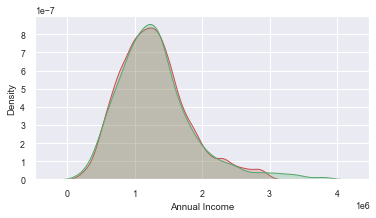

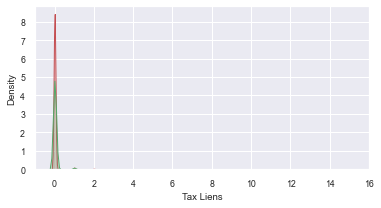

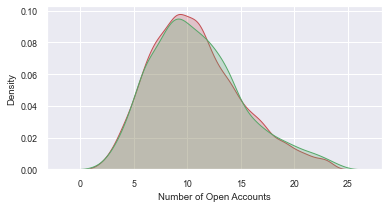

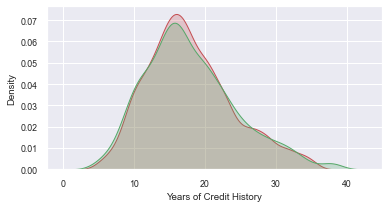

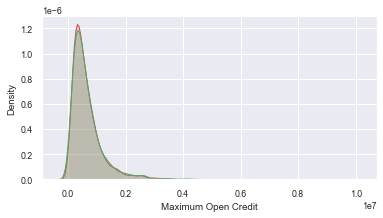

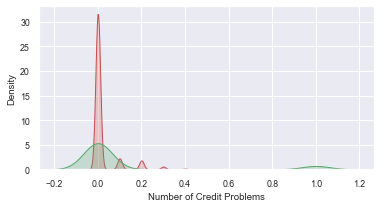

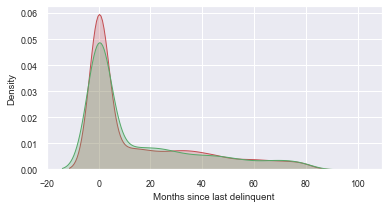

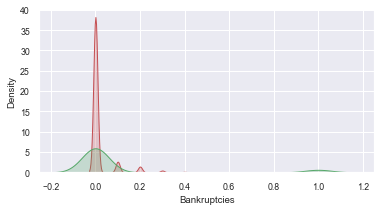

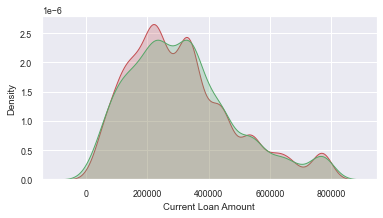

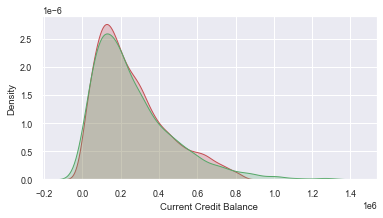

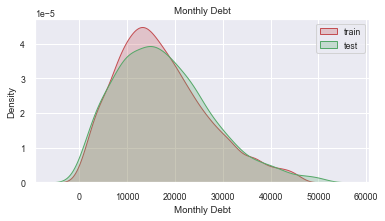

Credit Score


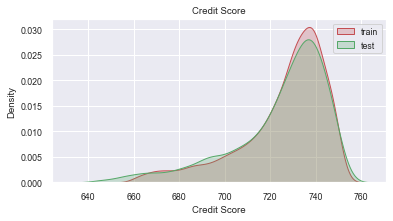

In [28]:
figsize = (6, 3)
for col in train_df.select_dtypes(exclude="category"):
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(train_df[col], shade=True, label='train', color='r')
    sns.kdeplot(test_df[col], shade=True, label='test', color='g')
    
    if shapiro(train_df[col])[1]>0.05:
        mean_prob = ttest_ind(train_df[col], test_df[col])[1]
    else:
        mean_prob = mannwhitneyu(train_df[col], test_df[col])[1]
    
    if mean_prob < 0.05:
        print(col)
        plt.legend()
        plt.title(col)
        plt.show()
        plt.close()

## Проверим корреляцию с целевой переменной

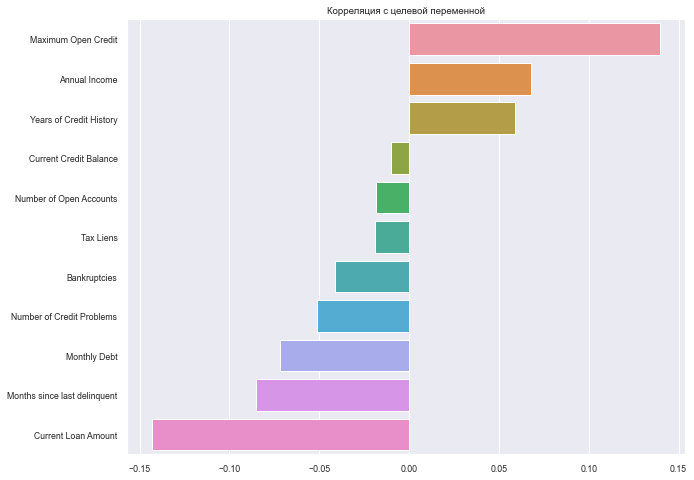

In [29]:
corr_with_target = train_df.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Корреляция с целевой переменной')
plt.show()

## Проверим распределения категориальных признаков на трейне и тесте

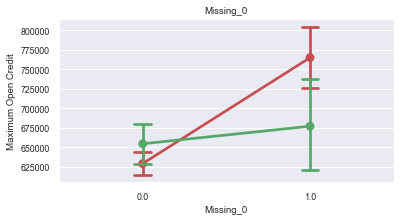

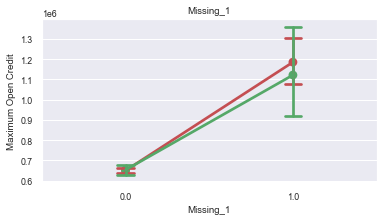

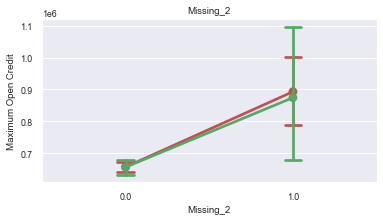

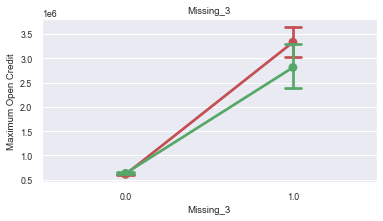

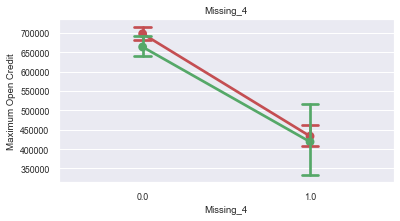

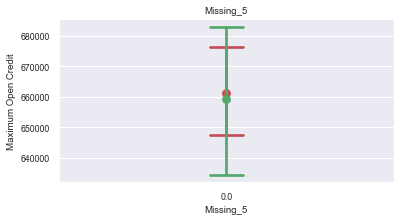

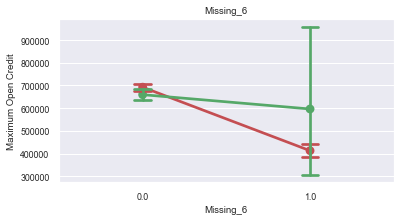

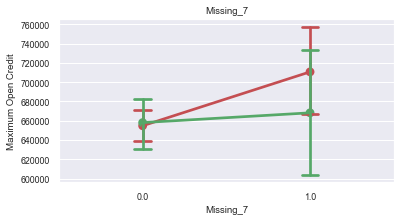

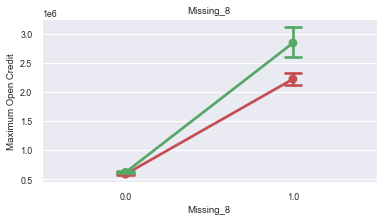

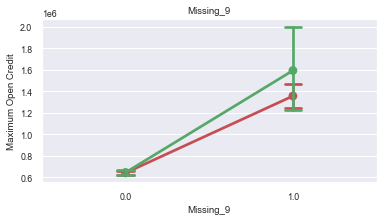

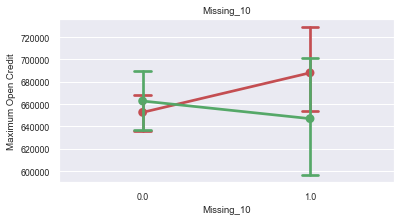

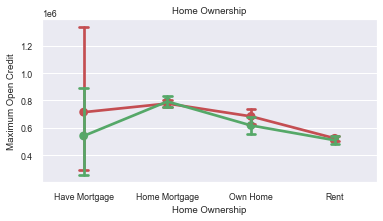

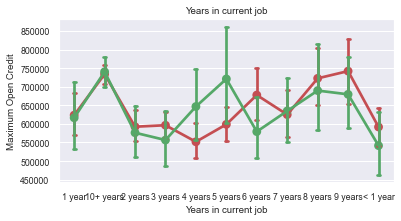

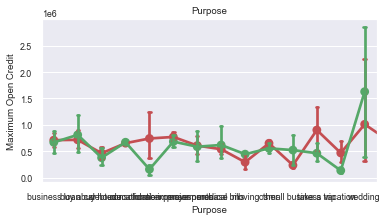

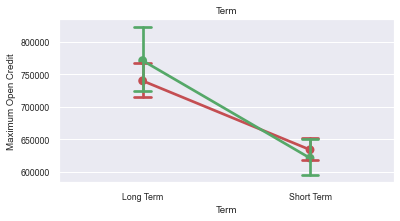

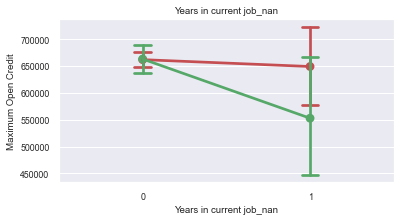

In [30]:
num_feature = 'Maximum Open Credit'
for col in test_df.select_dtypes(include="category"):
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=train_df, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=test_df, capsize=.1, label='test', color='g')
    plt.title(col)
    plt.show()

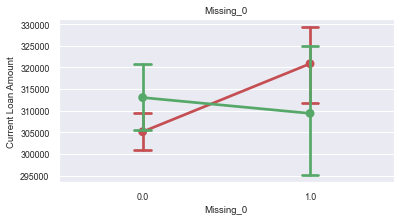

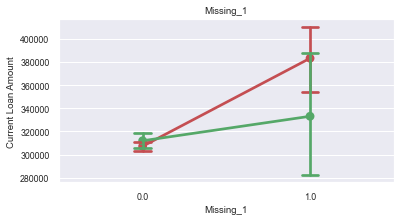

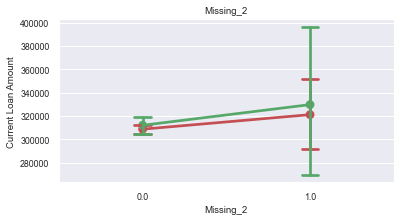

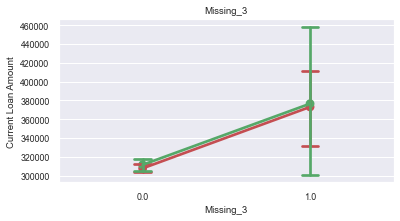

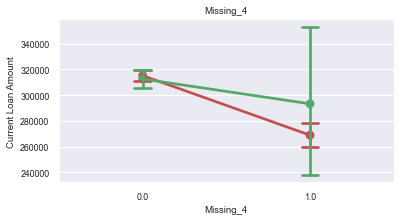

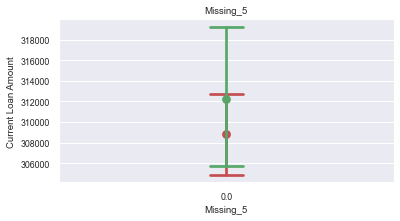

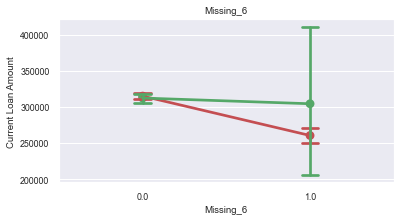

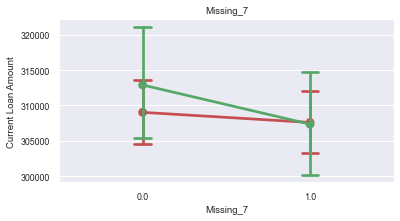

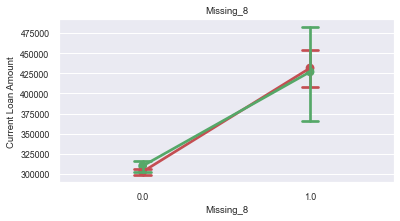

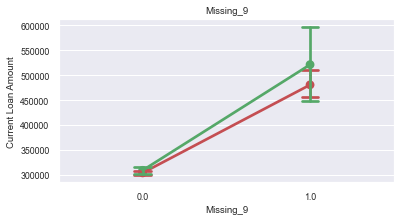

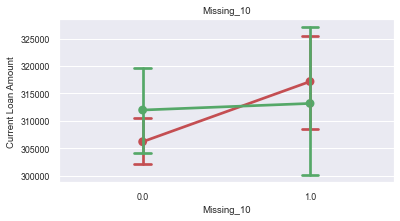

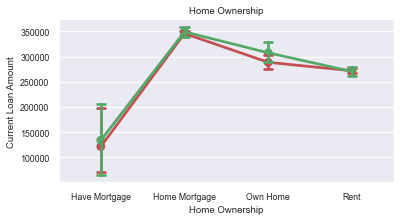

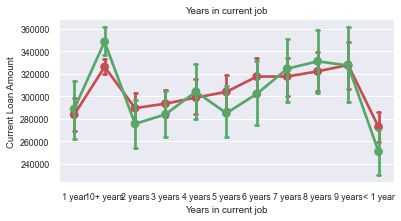

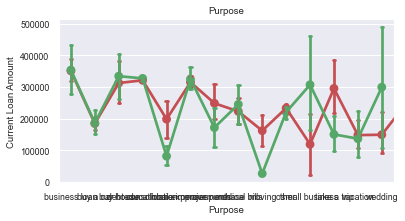

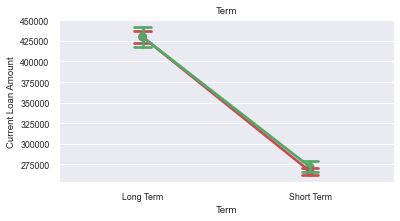

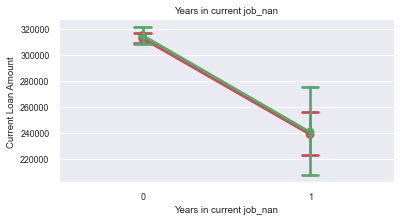

In [31]:
num_feature = 'Current Loan Amount'
for col in test_df.select_dtypes(include="category"):
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=train_df, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=test_df, capsize=.1, label='test', color='g')
    plt.title(col)
    plt.show()

## Проверим согласованность частот

In [32]:
import itertools

def check_consistency(df, y, feature, show=True):
    """Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
    Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
    Критерий: Хи-квадрат Пирсона
    Уровень значимости  𝛼 : 0.05
    Критическая область: двухсторонняя"""
        
    combineable = []
    variants = set(itertools.combinations(df[feature].unique(), 2))
    full_df = pd.concat([df, y], axis=1)
    full_df['Id'] = full_df.index
    for variant in variants:
        feature_and_target = full_df.loc[full_df[feature].isin(variant), ['Id', feature, 'Credit Default']]
        table = feature_and_target.pivot_table(values='Id', index=feature, columns='Credit Default', aggfunc='count')
        table = table[(table.T != 0).any()]

        chi2, p, _, _ = chi2_contingency(table)
        if p>0.05:
            combineable.append(variant)
    if show:
        plt.figure(figsize=(10, 8))
        sns.pointplot(x=feature, y=y, data=df, capsize=.1,)
        plt.show()
        plt.close()

        print(f"Признаки, которые можно объединить в {feature}: {combineable}")
    else:
        return(len(combineable))

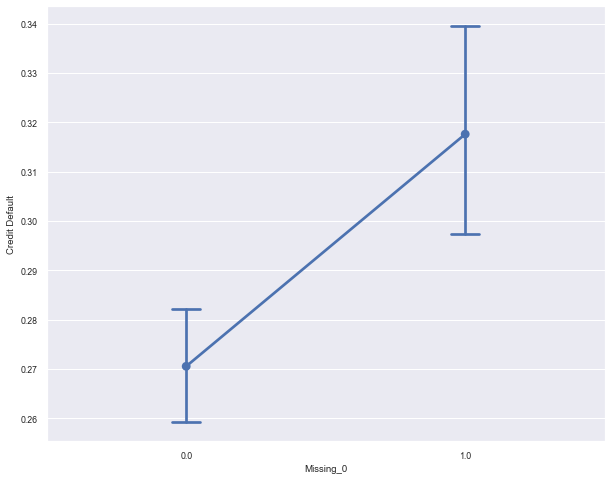

Признаки, которые можно объединить в Missing_0: []


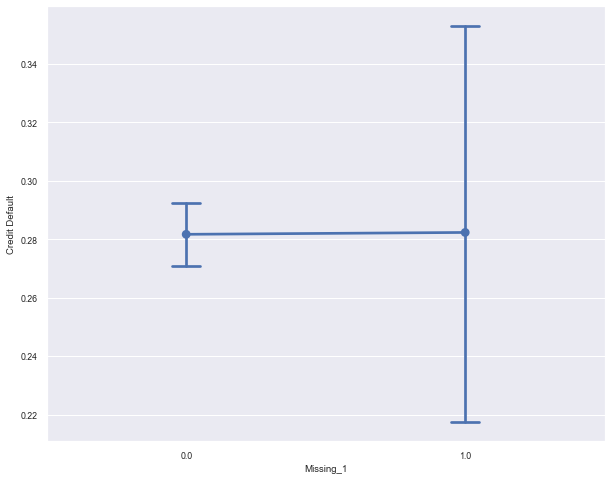

Признаки, которые можно объединить в Missing_1: [(0.0, 1.0)]


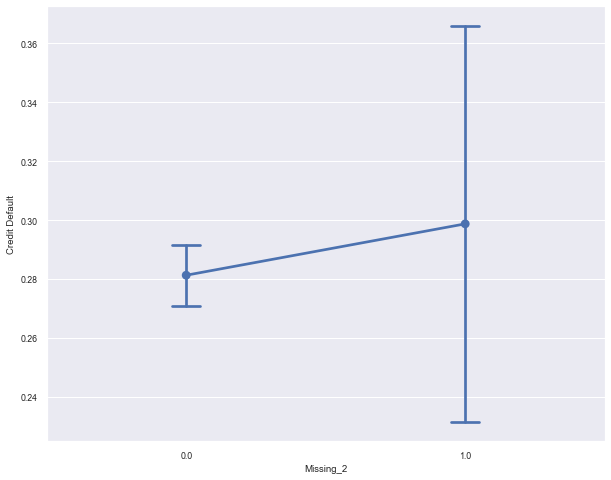

Признаки, которые можно объединить в Missing_2: [(0.0, 1.0)]


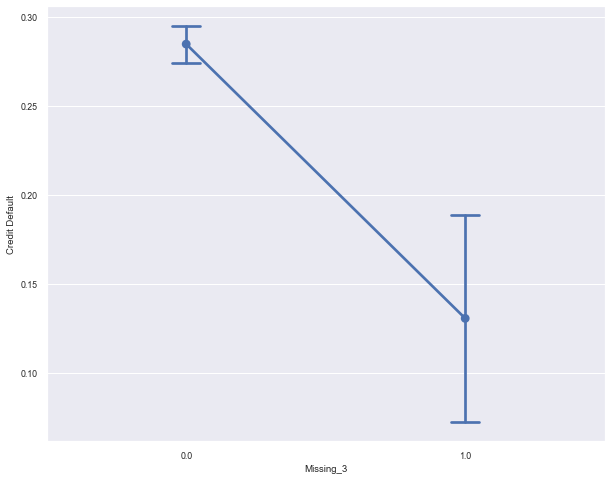

Признаки, которые можно объединить в Missing_3: []


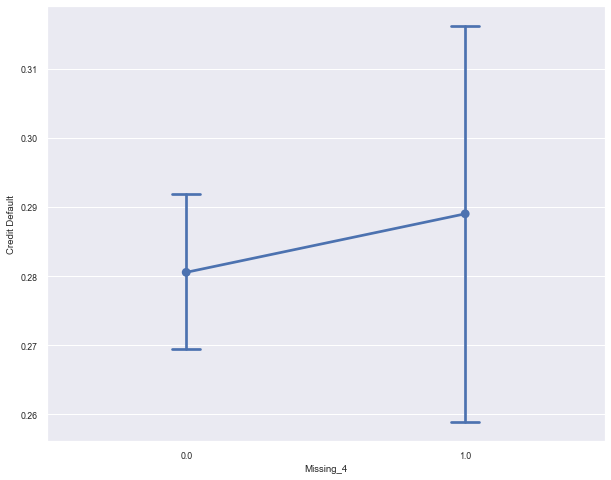

Признаки, которые можно объединить в Missing_4: [(1.0, 0.0)]


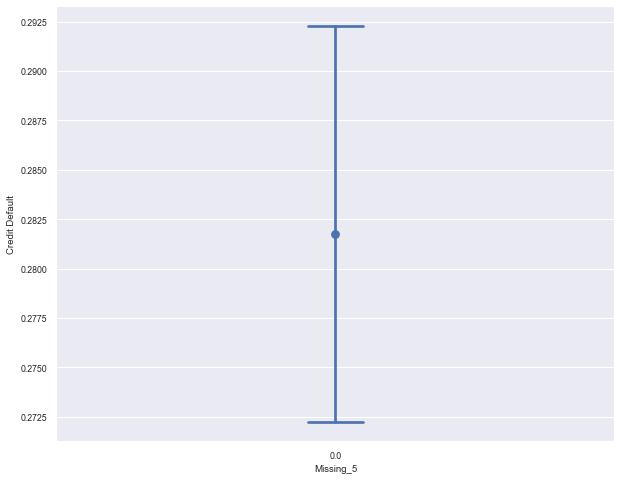

Признаки, которые можно объединить в Missing_5: []


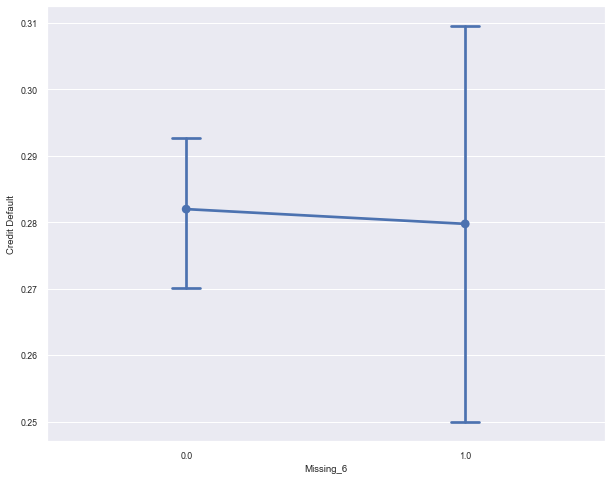

Признаки, которые можно объединить в Missing_6: [(1.0, 0.0)]


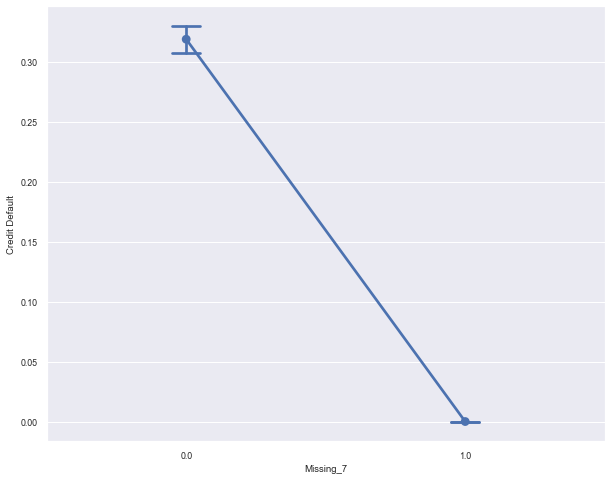

Признаки, которые можно объединить в Missing_7: []


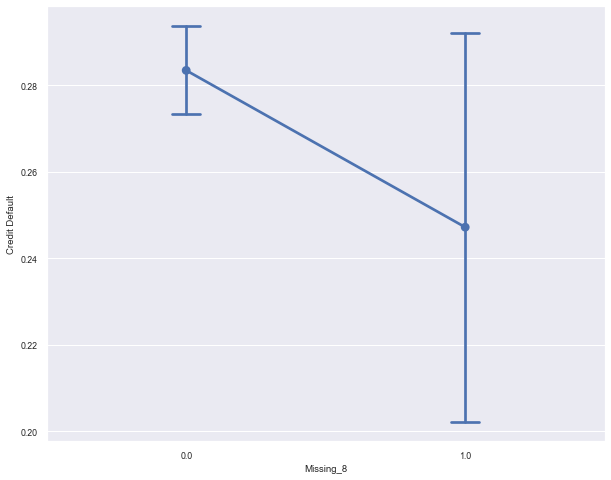

Признаки, которые можно объединить в Missing_8: [(0.0, 1.0)]


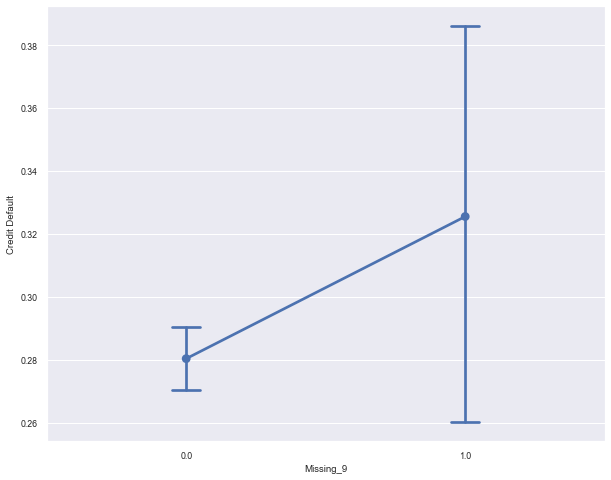

Признаки, которые можно объединить в Missing_9: [(0.0, 1.0)]


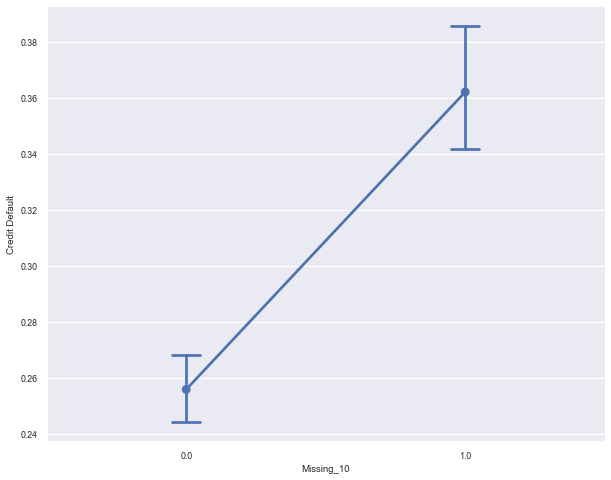

Признаки, которые можно объединить в Missing_10: []


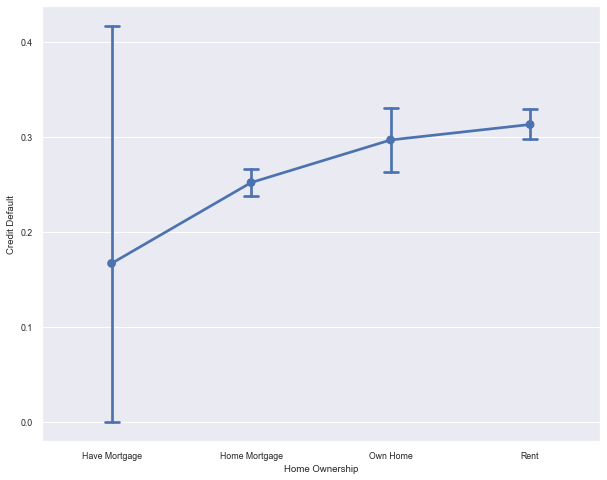

Признаки, которые можно объединить в Home Ownership: [('Own Home', 'Rent'), ('Own Home', 'Have Mortgage'), ('Rent', 'Have Mortgage'), ('Home Mortgage', 'Have Mortgage')]


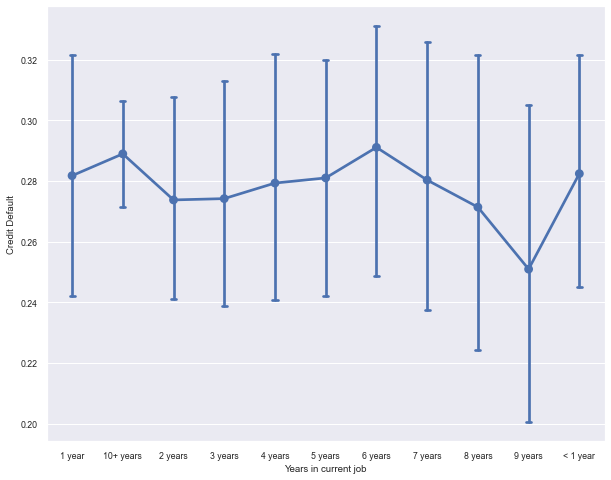

Признаки, которые можно объединить в Years in current job: [('1 year', '3 years'), ('1 year', '9 years'), ('8 years', '1 year'), ('6 years', '7 years'), ('8 years', '7 years'), ('4 years', '9 years'), ('5 years', '1 year'), ('1 year', '2 years'), ('4 years', '3 years'), ('10+ years', '8 years'), ('10+ years', '6 years'), ('10+ years', '3 years'), ('10+ years', '9 years'), ('1 year', '4 years'), ('3 years', '9 years'), ('4 years', '2 years'), ('7 years', '9 years'), ('1 year', '< 1 year'), ('7 years', '3 years'), ('10+ years', '2 years'), ('6 years', '3 years'), ('6 years', '9 years'), ('3 years', '2 years'), ('10+ years', '5 years'), ('8 years', '6 years'), ('8 years', '3 years'), ('8 years', '9 years'), ('5 years', '9 years'), ('7 years', '2 years'), ('5 years', '3 years'), ('6 years', '2 years'), ('10+ years', '< 1 year'), ('10+ years', '4 years'), ('7 years', '5 years'), ('< 1 year', '3 years'), ('< 1 year', '9 years'), ('8 years', '2 years'), ('6 years', '5 years'), ('5 years', '2 

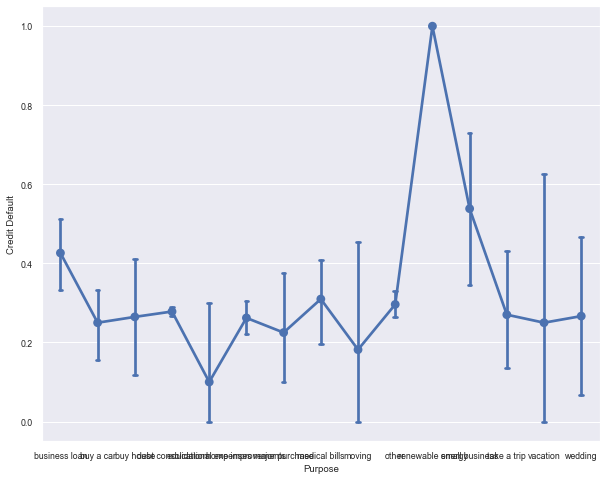

Признаки, которые можно объединить в Purpose: [('wedding', 'renewable energy'), ('buy a car', 'wedding'), ('home improvements', 'major purchase'), ('home improvements', 'buy house'), ('small business', 'moving'), ('medical bills', 'moving'), ('business loan', 'moving'), ('business loan', 'educational expenses'), ('other', 'buy house'), ('medical bills', 'major purchase'), ('home improvements', 'wedding'), ('debt consolidation', 'medical bills'), ('business loan', 'buy house'), ('buy house', 'moving'), ('debt consolidation', 'moving'), ('major purchase', 'vacation'), ('small business', 'wedding'), ('take a trip', 'small business'), ('wedding', 'moving'), ('buy house', 'major purchase'), ('business loan', 'wedding'), ('wedding', 'educational expenses'), ('buy a car', 'educational expenses'), ('home improvements', 'take a trip'), ('debt consolidation', 'buy house'), ('wedding', 'major purchase'), ('wedding', 'buy house'), ('take a trip', 'vacation'), ('major purchase', 'renewable energy')

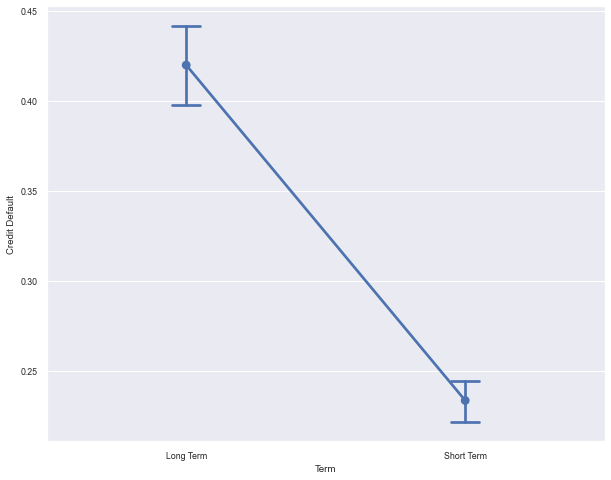

Признаки, которые можно объединить в Term: []


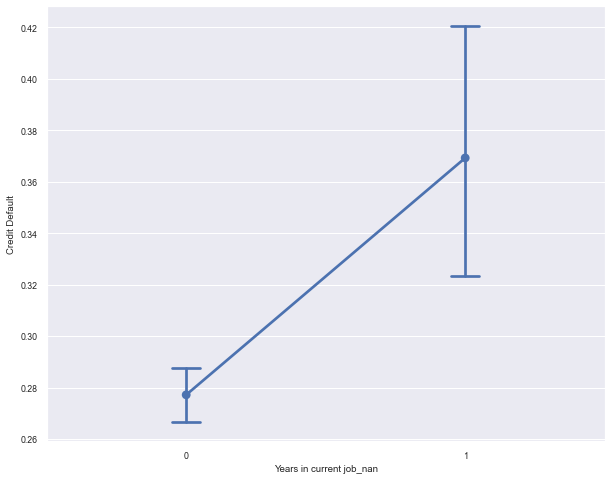

Признаки, которые можно объединить в Years in current job_nan: []


In [33]:
for feature in train_df.select_dtypes(include="category").columns:
    check_consistency(train_df, y, feature)

In [34]:
# from sklearn.manifold import TSNE
# tsne = TSNE(n_components = 2, learning_rate=30, random_state=42, perplexity=30, n_iter=500)
# X_train_tsne = tsne.fit_transform(pd.get_dummies(train_df))
# plt.scatter(X_train_tsne[:, 0], X_train_tsne[:,1])

### Перепробовал массу вариантов с разными параметрами, ничего не видно...

In [35]:
def apply_elbow_method(X):
    """Визуализация для метода 'локтя'"""
    X = pd.get_dummies(X)
    
    distortions = []
    K = range(2,30)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=42).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    plt.figure(figsize=(10, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [36]:
# apply_elbow_method(train_df)

In [37]:
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(pd.get_dummies(train_df))

# kmeans = KMeans(n_clusters=13, random_state=42)
# labels = kmeans.fit_predict(X_scaled)
# labels = pd.Series(labels, name='clusters')

# display_clusters_distribution(labels)

### Выглядит прилично, добавим в данные

## Добавим новые признаки

In [38]:
class FeatureGenerator:
    def fit(self, df, target):
        full_df = pd.concat([df,target], axis=1)
        self.purpose_count = df["Purpose"].value_counts().reset_index().rename(columns={"index":"Purpose", "Purpose":"PurposeCount"})
        self.yicj_def = full_df.groupby("Years in current job")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_YICJ_proba"})
        self.purpose_def = full_df.groupby("Purpose")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_Purp_prob"})
        self.def_proba_per_problems = full_df.groupby("Number of Credit Problems")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_NOCP_prob"})
        self.tax_def = full_df.groupby("Tax Liens")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_TL_prob"})
        self.acc_def = full_df.groupby("Number of Open Accounts")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_NOA_prob"})
        self.delinquent_def = full_df.groupby("Months since last delinquent")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_del_prob"})
        self.bankr_def = full_df.groupby("Bankruptcies")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_bankr_prob"})    
        self.yoch_def = full_df.groupby("Years of Credit History")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_YOCH_prob"})
        self.ho_def = full_df.groupby("Home Ownership")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_HO_prob"})
        self.cs_def = full_df.groupby("Credit Score")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_CS_prob"})
        self.term_def = full_df.groupby("Term")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_term_prob"})
        self.cs_nocp = full_df.groupby("Credit Score")["Number of Credit Problems"].agg("mean").reset_index().rename(columns={"Number of Credit Problems":"CS_NOCP"})
        
        self.enc = OneHotEncoder(sparse=False, handle_unknown="ignore")
        df_cat = pd.DataFrame(self.enc.fit_transform(df.select_dtypes(include="category")))
        df_num = df.select_dtypes(exclude="category")
        df_dummies = pd.concat([df_num, df_cat], axis=1)
        
        self.scaler = MinMaxScaler()
        df_scaled = self.scaler.fit_transform(df_dummies)
        self.kmeans = KMeans(n_clusters=13, random_state=42)
        self.kmeans.fit(df_scaled)

        self.pcas = dict()
        for feature in df.select_dtypes(include="category").columns:
            if check_consistency(df, y, feature, show=False) > 3:
                pca = PCA(n_components=df[feature].nunique()//2)
                enc = OneHotEncoder(sparse=False, handle_unknown="ignore")
                dummies = enc.fit_transform(pd.DataFrame(df[feature]))
                pca.fit(dummies)
                self.pcas[feature]=(pca, enc)
        
        
        
    def transform(self, df):
        df_cat = pd.DataFrame(self.enc.transform(df.select_dtypes(include="category")))
        df_num = df.select_dtypes(exclude="category")
        df_dummies = pd.concat([df_num, df_cat], axis=1)
        
        df_scaled = self.scaler.transform(df_dummies)
        kmeans_labels = pd.Series(self.kmeans.predict(df_scaled), name='cluster').astype("category")
        df = pd.concat([df, kmeans_labels], axis=1)
        
        # target encoding
        df = df.merge(self.purpose_count, on="Purpose", how="left")
        df = df.merge(self.purpose_def, on="Purpose", how="left")
        df = df.merge(self.yicj_def, on="Years in current job", how="left")
        df = df.merge(self.def_proba_per_problems, on="Number of Credit Problems", how="left")
        df = df.merge(self.tax_def, on="Tax Liens", how="left")
        df = df.merge(self.acc_def, on="Number of Open Accounts", how="left")
        df = df.merge(self.delinquent_def, on="Months since last delinquent", how="left")
        df = df.merge(self.bankr_def, on="Bankruptcies", how="left")
        df = df.merge(self.yoch_def, on="Years of Credit History", how="left")
        df = df.merge(self.ho_def, on="Home Ownership", how="left")
        df = df.merge(self.cs_def, on="Credit Score", how="left")
        df = df.merge(self.term_def, on="Term", how="left")
        df = df.merge(self.cs_nocp, on="Credit Score", how="left")
                
        
        # feature encoding
        df["Debt_to_income"] = df["Monthly Debt"]/(df["Annual Income"])
        df["Income_to_debt"] = (df["Annual Income"])/df["Monthly Debt"]
        df["Income_to_loan"] = (df["Annual Income"])/df["Current Loan Amount"]
        df["Payback_period"] = df["Current Loan Amount"]/df["Annual Income"]
        df["Payback_period_2"] = df["Current Credit Balance"]/df["Annual Income"]
        df["Payback_period_3"] = (df["Current Loan Amount"] + df["Current Credit Balance"])/df["Annual Income"]
        df["Loan left"] = df["Current Loan Amount"]/df["Maximum Open Credit"]
        df["Loan left_2"] = df["Maximum Open Credit"]/df["Current Loan Amount"]
        df["Loan_to_credit_ratio"] = df["Current Loan Amount"]/df["Current Credit Balance"]
        df["Credit left"] = df["Current Credit Balance"]/df["Maximum Open Credit"]
        df["Problems per credit"] = df["Number of Credit Problems"]/df["Maximum Open Credit"]
        df["Income per credit"] = df["Annual Income"]/df["Maximum Open Credit"]
        df["Problems per account"] = df["Number of Credit Problems"]/df["Number of Open Accounts"]
                
        # заменим некторые категории на PCA
        for feature, value in self.pcas.items():
            pca = value[0]
            enc = value[1]
            reduced = pd.DataFrame(pca.transform(enc.transform(pd.DataFrame(df[feature]))))
            columns = reduced.columns.tolist()
            columns = {col: feature+"_reduced_"+str(col) for col in columns}
            reduced.rename(columns=columns, inplace=True)
            df = pd.concat([df, reduced], axis=1)
            for col in str(df_cat.columns.tolist()):
                if feature.lower() in col.lower():
                    df_cat.drop(col, axis=1, inplace=True)
        
#         # разобъём данные на квантили
#         quantiles = 10
#         new_cat = pd.DataFrame()
#         for feature in df.columns:
#             try:
#                 if df[feature].nunique() > 50:
#                     #print(f"Working on {feature}, uniques = {df[feature].nunique()}")
#                     new_cat[feature + "_quant"] = pd.qcut(df[feature],
#                                                   q=np.linspace(0, 1, quantiles+1), # (0, .25, .5, .75, 1.)
#                                                   labels=range(quantiles), # (0, 1, 2, 3)
#                                                   duplicates="drop")#.astype("category") 
#             except KeyError:
#                 #print(f"{feature} raised KeyError!")
#                 continue
#             except ValueError:
#                 #print(f"{feature} raised ValueError!")
#                 continue
#         final_num = df.select_dtypes(exclude="category")
#         final_df = pd.concat([final_num, new_cat, df_cat], axis=1)
        
        final_df = df
        
        # если есть медианы - заполняем пропуски, нет - генерим медианы
        try:
            final_df.fillna(self.medians, inplace=True)
            final_df.fillna(self.modes, inplace=True)
            for feature in final_df.columns:
                try:
                    final_df[feature] = final_df[feature].replace(np.inf, final_df[feature].median())
                except TypeError:
                    continue
            
        except:
            self.medians = final_df.median()
            self.modes = final_df.mode()
            for feature in final_df.columns:
                try:
                    final_df[feature] = final_df[feature].replace(np.inf, final_df[feature].median())
                except TypeError:
                    continue        
        
        return final_df

In [39]:
feature_generator = FeatureGenerator()
feature_generator.fit(train_df, y)
train_df = feature_generator.transform(train_df)
test_df = feature_generator.transform(test_df)

In [40]:
# проверим пропуски
print(f"Train NaNs: {train_df.isna().sum().sum()}")
print(f"Test Nans: {test_df.isna().sum().sum()}")
print(test_df.columns[test_df.isna().any()].tolist())

Train NaNs: 0
Test Nans: 0
[]


## Проверим эффективность признаков

In [41]:
X_train, X_test, y_train, y_test = get_splitted(train_df, y)

model_lr = LogisticRegressionCV()
model_lr.fit(X_train, y_train)

evaluate_preds(model_lr, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.92      0.85      3771
           1       0.66      0.40      0.50      1479

    accuracy                           0.77      5250
   macro avg       0.73      0.66      0.67      5250
weighted avg       0.76      0.77      0.75      5250

TEST

              precision    recall  f1-score   support

           0       0.79      0.92      0.85      1616
           1       0.64      0.37      0.47       634

    accuracy                           0.76      2250
   macro avg       0.71      0.64      0.66      2250
weighted avg       0.75      0.76      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1484  132
1                400  234


## KNN

In [42]:
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

evaluate_preds(model_knn, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      3771
           1       0.67      0.43      0.53      1479

    accuracy                           0.78      5250
   macro avg       0.74      0.68      0.69      5250
weighted avg       0.77      0.78      0.76      5250

TEST

              precision    recall  f1-score   support

           0       0.75      0.85      0.80      1616
           1       0.41      0.26      0.32       634

    accuracy                           0.69      2250
   macro avg       0.58      0.56      0.56      2250
weighted avg       0.65      0.69      0.66      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1381  235
1                468  166


## Дерево решений

In [43]:
y.value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [44]:
disbalance = round(y.value_counts().max()/y.value_counts().min(),2)
disbalance

2.55

In [45]:
from sklearn.tree import DecisionTreeClassifier
model_tree = DecisionTreeClassifier(random_state=21,
                                    class_weight={0:1, 1:disbalance},
                                    max_depth=4
                                    )
# from yellowbrick.classifier.threshold import discrimination_threshold
# from yellowbrick.classifier import DiscriminationThreshold

# # Instantiate the visualizer with the classification model
# #discrimination_threshold(final_model, X_train, y_train)
# visualizer = DiscriminationThreshold(model_tree)
# visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
# visualizer.show()

model_tree.fit(X_train, y_train)

evaluate_preds(model_tree, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.50      0.65      3771
           1       0.40      0.85      0.55      1479

    accuracy                           0.60      5250
   macro avg       0.65      0.68      0.60      5250
weighted avg       0.76      0.60      0.62      5250

TEST

              precision    recall  f1-score   support

           0       0.89      0.52      0.65      1616
           1       0.40      0.84      0.54       634

    accuracy                           0.61      2250
   macro avg       0.65      0.68      0.60      2250
weighted avg       0.75      0.61      0.62      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               833  783
1               104  530


## Бустинговые алгоритмы

*XGBoost*

In [46]:
%%time
from xgboost import XGBClassifier

model_xgb = XGBClassifier(random_state=42,
#                               n_estimators=100
                             )
model_xgb.fit(X_train, y_train)

evaluate_preds(model_xgb, X_train, X_test, y_train, y_test)

[18:48:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3771
           1       1.00      0.96      0.98      1479

    accuracy                           0.99      5250
   macro avg       0.99      0.98      0.99      5250
weighted avg       0.99      0.99      0.99      5250

TEST

              precision    recall  f1-score   support

           0       0.78      0.89      0.83      1616
           1       0.56      0.36      0.43       634

    accuracy                           0.74      2250
   macro avg       0.67      0.62      0.63      2250
weighted avg       0.72      0.74      0.72      2250

CONFUSION MATRIX

col_0

Жуткое переобучение

*LightGBM*

In [47]:
%%time
from lightgbm import LGBMClassifier
model_lgbm = LGBMClassifier(random_state=42, 
                                 class_weight={0:1, 1:disbalance},
#                                  n_estimators=100
                                )
model_lgbm.fit(X_train, y_train)

evaluate_preds(model_lgbm, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.92      0.96      3771
           1       0.83      0.98      0.90      1479

    accuracy                           0.94      5250
   macro avg       0.91      0.95      0.93      5250
weighted avg       0.95      0.94      0.94      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.76      0.80      1616
           1       0.50      0.60      0.54       634

    accuracy                           0.72      2250
   macro avg       0.66      0.68      0.67      2250
weighted avg       0.74      0.72      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1236  380
1                256  378
Wall time: 359 ms


Не намного лучше

*CatBoost*

In [48]:
%%time
from catboost import CatBoostClassifier
model_catb = CatBoostClassifier(silent=True, random_state=42,
                               class_weights=[1,disbalance])
model_catb.fit(X_train, y_train)

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.89      0.93      3771
           1       0.77      0.95      0.85      1479

    accuracy                           0.90      5250
   macro avg       0.87      0.92      0.89      5250
weighted avg       0.92      0.90      0.91      5250

TEST

              precision    recall  f1-score   support

           0       0.84      0.76      0.80      1616
           1       0.51      0.64      0.57       634

    accuracy                           0.72      2250
   macro avg       0.68      0.70      0.68      2250
weighted avg       0.75      0.72      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1221  395
1                227  407
Wall time: 7.94 s


In [49]:
categories = train_df.select_dtypes(include="category").columns.tolist()
categories

['Missing_0',
 'Missing_1',
 'Missing_2',
 'Missing_3',
 'Missing_4',
 'Missing_5',
 'Missing_6',
 'Missing_7',
 'Missing_8',
 'Missing_9',
 'Missing_10',
 'Home Ownership',
 'Years in current job',
 'Purpose',
 'Term',
 'Years in current job_nan',
 'cluster']

In [50]:
# catboost'у не понравились первые столбцы, переведём их в строки
for feature in categories:
    train_df[feature] = train_df[feature].astype("str")

In [51]:
X_train, X_test, y_train, y_test = train_test_split(train_df, y,
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

model_catb = CatBoostClassifier(silent=True, random_state=42,
                                class_weights=[1,disbalance],
                                cat_features=categories,
                                eval_metric='F1',
                                early_stopping_rounds=20,
                                use_best_model=True,
                                custom_metric=['Precision', 'Recall'])
#model_catb.fit(X_train, y_train)
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.55      0.68      3771
           1       0.41      0.80      0.54      1479

    accuracy                           0.62      5250
   macro avg       0.64      0.68      0.61      5250
weighted avg       0.75      0.62      0.64      5250

TEST

              precision    recall  f1-score   support

           0       0.88      0.58      0.70      1616
           1       0.43      0.79      0.56       634

    accuracy                           0.64      2250
   macro avg       0.65      0.69      0.63      2250
weighted avg       0.75      0.64      0.66      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               940  676
1               130  504


## Выбор лучшей модели и подбор гиперпараметров

In [52]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':42,
     'cat_features':categories,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}
model_catb = CatBoostClassifier(**frozen_params)

In [53]:
params = {'iterations':[50, 200, 500, 700, 1500],
          'max_depth':[3, 5, 7]}

In [54]:
cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

In [55]:
grid_search = model_catb.grid_search(params, X_train, y_train, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6883003901
bestIteration = 3

0:	loss: 0.6883004	best: 0.6883004 (0)	total: 441ms	remaining: 6.17s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7063666803
bestIteration = 90

1:	loss: 0.7063667	best: 0.7063667 (1)	total: 2.14s	remaining: 13.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7063666803
bestIteration = 90

2:	loss: 0.7063667	best: 0.7063667 (1)	total: 3.71s	remaining: 14.8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7063666803
bestIteration = 90

3:	loss: 0.7063667	best: 0.7063667 (1)	total: 5.12s	remaining: 14.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7063666803
bestIteration = 90

4:	loss: 0.7063667	best: 0.7063667 (1)	total: 6.68s	remaining: 13.4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6860706834
bestIteration = 1

5:	loss: 0.6860707	best: 0.7063667 (1)	total: 7.12s	remaining: 

In [56]:
grid_search["params"]

{'depth': 3, 'iterations': 200}

## Обучение и оценка финальной модели

In [57]:
%%time

final_model = CatBoostClassifier(**frozen_params, iterations=200, max_depth=7)

# from yellowbrick.classifier.threshold import discrimination_threshold
# from yellowbrick.classifier import DiscriminationThreshold

# Instantiate the visualizer with the classification model
#discrimination_threshold(final_model, X_train, y_train)
# visualizer = DiscriminationThreshold(final_model)
# visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
# visualizer.show()

final_model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(final_model, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.72      0.80      3771
           1       0.54      0.82      0.65      1479

    accuracy                           0.75      5250
   macro avg       0.72      0.77      0.73      5250
weighted avg       0.81      0.75      0.76      5250

TEST

              precision    recall  f1-score   support

           0       0.87      0.69      0.77      1616
           1       0.49      0.74      0.59       634

    accuracy                           0.71      2250
   macro avg       0.68      0.72      0.68      2250
weighted avg       0.76      0.71      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1119  497
1                165  469
Wall time: 3.2 s


## Балансировка целевой переменной

In [58]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [59]:
def init_models():
    model_lr = LogisticRegressionCV(random_state=42)
    model_knn = KNeighborsClassifier()
    model_tree = DecisionTreeClassifier(random_state=42)
    model_xgb = XGBClassifier(random_state=42)
    model_lgbm = LGBMClassifier(random_state=42)
    model_catb = CatBoostClassifier(silent=True, random_state=42)

    models = {
        'lr': model_lr,
        'knn': model_knn,
        'tree': model_tree,
        'xgb': model_xgb,
        'lgbm': model_lgbm,
        'cat': model_catb
    }
    return models

In [60]:
def get_metrics(report):
    f1_macro = report['macro avg']['f1-score']
    f1_0 = report['0']['f1-score']
    f1_1 = report['1']['f1-score']
    return f1_macro, f1_0, f1_1

In [61]:
def run_experiment(X_train, X_test, y_train, y_test, method='not'):
    assert method in ['not', 'over', 'under', 'tomek', 'smote'], 'Неправильный метод сэмплирования'
    
    models = init_models()
    
    stata = pd.DataFrame()
    for name, model in models.items():
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)

        report_train = classification_report(y_train, pred_train, output_dict=True)
        report_test = classification_report(y_test, pred_test, output_dict=True)
        #f1_macro_train, f1_0_train, f1_1_train = get_metrics(report_train)
        f1_macro_test, f1_0_test, f1_1_test = get_metrics(report_test)

        stata = stata.append({
            'model_name': name,
            #f'f1_macro_train_{method}': f1_macro_train,
            f'f1_macro_test_{method}': f1_macro_test,
            #f'f1_0_train_{method}': f1_0_train,
            f'f1_0_test_{method}': f1_0_test,
            #f'f1_1_train_{method}': f1_1_train,
            f'f1_1_test_{method}': f1_1_test
        }, ignore_index=True)
    return stata, models

In [62]:
X_train, X_test, y_train, y_test = get_splitted(reduce_mem_usage(train_df), y)
#X_train, X_test, y_train, y_test = get_splitted(train_df, y)
stata_not_balanced, models_not_balanced = run_experiment(X_train, X_test, y_train, y_test, method='not')
stata_not_balanced

Memory usage of dataframe is 3.26 MB
Memory usage after optimization is: 1.66 MB
Decreased by 49.2%
[18:49:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


f1_0_test_not  f1_1_test_not  f1_macro_test_not model_name
0       0.849432       0.459184           0.654308         lr
1       0.797114       0.320773           0.558943        knn
2       0.752506       0.396024           0.574265       tree
3       0.830058       0.434615           0.632337        xgb
4       0.834763       0.423154           0.628958       lgbm
5       0.842016       0.423554           0.632785        cat

*Oversampling*

In [63]:
from imblearn.over_sampling import SMOTE
X_train, X_test, y_train, y_test = get_splitted(train_df, y)

oversample = SMOTE(n_jobs=-1, k_neighbors=10)
print(f"Original dataset shape: {X_train.shape}, {y_train.shape}")
X_res, y_res = oversample.fit_resample(X_train, y_train)
print(f"Resampled dataset shape: {X_res.shape}, {y_res.shape}")

Original dataset shape: (5250, 120), (5250,)
Resampled dataset shape: (7542, 120), (7542,)


In [64]:
smote_balanced, models_balanced = run_experiment(X_res, X_test, y_res, y_test, method='smote')
smote_balanced

[18:49:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


f1_0_test_smote  f1_1_test_smote  f1_macro_test_smote model_name
0         0.788207         0.596514             0.692361         lr
1         0.681134         0.445526             0.563330        knn
2         0.755598         0.443959             0.599779       tree
3         0.814371         0.465517             0.639944        xgb
4         0.824625         0.500855             0.662740       lgbm
5         0.836114         0.519231             0.677673        cat

In [65]:
from imblearn.under_sampling import TomekLinks
tl = TomekLinks()
X_tomek, y_tomek = tl.fit_resample(X_train, y_train)

In [66]:
tomek_balanced, models_balanced = run_experiment(X_tomek, X_test, y_tomek, y_test, method='tomek')
tomek_balanced

[18:50:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


f1_0_test_tomek  f1_1_test_tomek  f1_macro_test_tomek model_name
0         0.842660         0.505980             0.674320         lr
1         0.778782         0.379019             0.578901        knn
2         0.765997         0.431402             0.598700       tree
3         0.819076         0.469869             0.644473        xgb
4         0.831660         0.488330             0.659995       lgbm
5         0.838106         0.486085             0.662096        cat

In [67]:
def correlation_matrix(df):
    df = df.copy()
#     df = pd.get_dummies(df)
    plt.figure(figsize=(20,20))
    sns.set(font_scale=0.8)
    corr_matrix = df.corr()
    corr_matrix = np.round(corr_matrix, 2)
    corr_matrix[np.abs(corr_matrix)<0.3] = 0
    sns.heatmap(corr_matrix, annot=True, linewidth=.5, cmap="coolwarm")
    plt.title("Матрица корреляции")
    plt.plot()

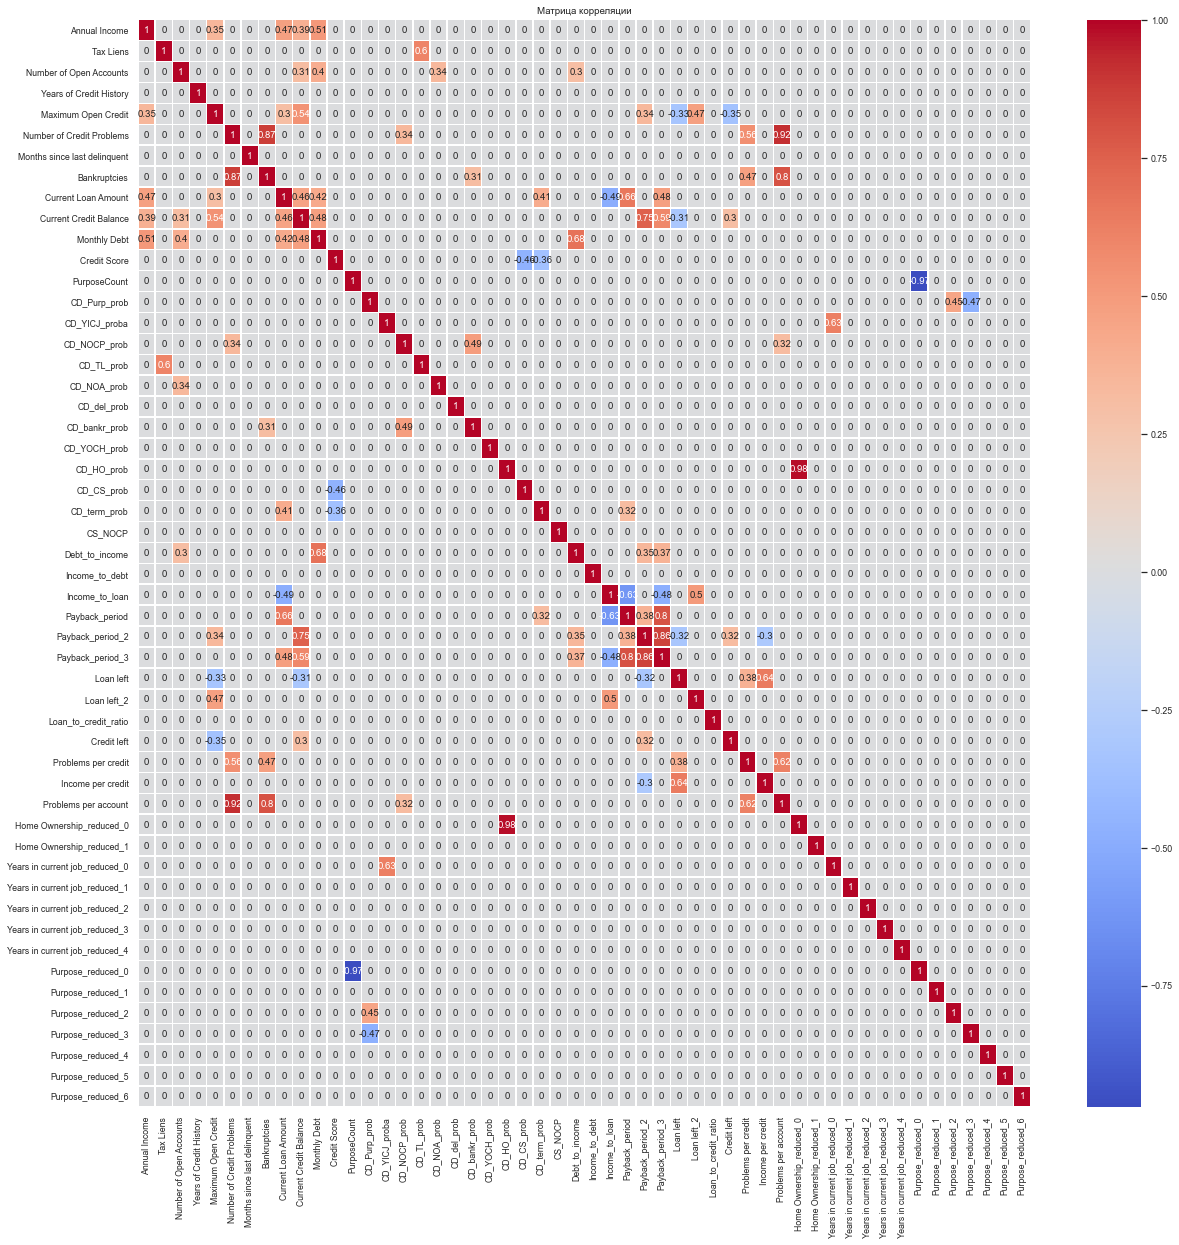

In [68]:
correlation_matrix(train_df)

### Выводы
Много кореллирующих данных, можно будет очень хорошо уменьшить размерность с помощью PCA

# Финальная финальная модель

In [69]:
final_train = pd.get_dummies(train_df)
final_test = pd.get_dummies(test_df)

In [70]:
train_cols = final_train.columns.to_list()
test_cols = final_test.columns.to_list()
cols_to_drop = set(train_cols) - set(test_cols)
final_train.drop(cols_to_drop, axis=1, inplace=True)

In [71]:
oversample = SMOTE(n_jobs=-1, k_neighbors=10)
print(f"Original dataset shape: {final_train.shape}, {y.shape}")
final_train, y = oversample.fit_resample(final_train, y)
print(f"Resampled dataset shape: {final_train.shape}, {y.shape}")

Original dataset shape: (7500, 119), (7500,)
Resampled dataset shape: (10774, 119), (10774,)


### Подбор финальных гиперпараметров

In [72]:
disbalance = round(y.value_counts().max()/y.value_counts().min(),2)
disbalance

1.0

In [73]:
frozen_params = {
     'silent':True,
     'random_state':42,
     'eval_metric':'F1',
     'early_stopping_rounds':20,
     'bagging_temperature': 1,
     'leaf_estimation_method': "Newton",
     'task_type':"CPU",
     'class_weights': [1, disbalance]
}
model = CatBoostClassifier(**frozen_params)

In [74]:
params = {'iterations': range(100,500,100),
          'max_depth':[3, 5, 7],
          'learning_rate' : [0.03, 0.1],
          'l2_leaf_reg': np.arange(2,8,0.1)
         }

In [75]:
cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(final_train, y,
                                                        shuffle=True,
                                                        test_size=0.3,
                                                        random_state=42,
                                                        stratify=y)

In [77]:
grid_search = model.grid_search(params, X_train, y_train, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8053333333
bestIteration = 49

0:	loss: 0.8053333	best: 0.8053333 (0)	total: 734ms	remaining: 17m 36s

bestTest = 0.8153846154
bestIteration = 99

1:	loss: 0.8153846	best: 0.8153846 (1)	total: 1.18s	remaining: 14m 11s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8061292472
bestIteration = 65

2:	loss: 0.8061292	best: 0.8153846 (1)	total: 1.74s	remaining: 13m 51s

bestTest = 0.8157894737
bestIteration = 93

3:	loss: 0.8157895	best: 0.8157895 (3)	total: 2.33s	remaining: 13m 57s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8112074716
bestIteration = 77

4:	loss: 0.8112075	best: 0.8157895 (3)	total: 2.94s	remaining: 14m 4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.814147018
bestIteration = 67

5:	loss: 0.8141470	best: 0.8157895 (3)	total: 3.42s	remaining: 13m 36s

bestTest = 0.8019323671
bestIteration = 97

6:	loss: 0.8019324	best: 0.8157895 (3)	total:

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8093922652
bestIteration = 47

53:	loss: 0.8093923	best: 0.8157895 (3)	total: 21.9s	remaining: 9m 22s

bestTest = 0.8064952639
bestIteration = 92

54:	loss: 0.8064953	best: 0.8157895 (3)	total: 22.4s	remaining: 9m 23s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8050139276
bestIteration = 40

55:	loss: 0.8050139	best: 0.8157895 (3)	total: 22.7s	remaining: 9m 20s

bestTest = 0.8092328581
bestIteration = 95

56:	loss: 0.8092329	best: 0.8157895 (3)	total: 23.2s	remaining: 9m 22s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8057259714
bestIteration = 25

57:	loss: 0.8057260	best: 0.8157895 (3)	total: 23.4s	remaining: 9m 17s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8080267559
bestIteration = 64

58:	loss: 0.8080268	best: 0.8157895 (3)	total: 23.8s	remaining: 9m 18s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8094248094
bestItera

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8076398363
bestIteration = 29

105:	loss: 0.8076398	best: 0.8196939 (99)	total: 42.3s	remaining: 8m 52s

bestTest = 0.8043184885
bestIteration = 91

106:	loss: 0.8043185	best: 0.8196939 (99)	total: 42.8s	remaining: 8m 52s

bestTest = 0.8119777159
bestIteration = 90

107:	loss: 0.8119777	best: 0.8196939 (99)	total: 43.3s	remaining: 8m 53s

bestTest = 0.8070175439
bestIteration = 82

108:	loss: 0.8070175	best: 0.8196939 (99)	total: 43.8s	remaining: 8m 55s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8107734807
bestIteration = 77

109:	loss: 0.8107735	best: 0.8196939 (99)	total: 44.4s	remaining: 8m 57s

bestTest = 0.8024523161
bestIteration = 98

110:	loss: 0.8024523	best: 0.8196939 (99)	total: 45s	remaining: 8m 58s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8096192385
bestIteration = 25

111:	loss: 0.8096192	best: 0.8196939 (99)	total: 45.2s	remaining: 8m 56s
Stopped by ove

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8105960265
bestIteration = 22

155:	loss: 0.8105960	best: 0.8196949 (123)	total: 1m 3s	remaining: 8m 45s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8068259386
bestIteration = 107

156:	loss: 0.8068259	best: 0.8196949 (123)	total: 1m 4s	remaining: 8m 47s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8136272545
bestIteration = 17

157:	loss: 0.8136273	best: 0.8196949 (123)	total: 1m 4s	remaining: 8m 45s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8051420839
bestIteration = 68

158:	loss: 0.8051421	best: 0.8196949 (123)	total: 1m 5s	remaining: 8m 44s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8093922652
bestIteration = 36

159:	loss: 0.8093923	best: 0.8196949 (123)	total: 1m 5s	remaining: 8m 43s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8049450549
bestIteration = 109

160:	loss: 0.8049451	best: 0.81969

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8049450549
bestIteration = 30

203:	loss: 0.8049451	best: 0.8214038 (161)	total: 1m 23s	remaining: 8m 23s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8024439919
bestIteration = 68

204:	loss: 0.8024440	best: 0.8214038 (161)	total: 1m 23s	remaining: 8m 24s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8098495212
bestIteration = 35

205:	loss: 0.8098495	best: 0.8214038 (161)	total: 1m 23s	remaining: 8m 22s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8043626449
bestIteration = 92

206:	loss: 0.8043626	best: 0.8214038 (161)	total: 1m 24s	remaining: 8m 24s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8067567568
bestIteration = 24

207:	loss: 0.8067568	best: 0.8214038 (161)	total: 1m 24s	remaining: 8m 23s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8029589778
bestIteration = 74

208:	loss: 0.8029590	best: 0.82

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8051595384
bestIteration = 28

251:	loss: 0.8051595	best: 0.8214038 (161)	total: 1m 47s	remaining: 8m 27s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8106630212
bestIteration = 98

252:	loss: 0.8106630	best: 0.8214038 (161)	total: 1m 48s	remaining: 8m 27s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8096219931
bestIteration = 37

253:	loss: 0.8096220	best: 0.8214038 (161)	total: 1m 48s	remaining: 8m 26s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8044914135
bestIteration = 51

254:	loss: 0.8044914	best: 0.8214038 (161)	total: 1m 48s	remaining: 8m 25s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8111413043
bestIteration = 44

255:	loss: 0.8111413	best: 0.8214038 (161)	total: 1m 49s	remaining: 8m 25s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8105906314
bestIteration = 87

256:	loss: 0.8105906	best: 0.82

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8094248094
bestIteration = 46

299:	loss: 0.8094248	best: 0.8214038 (161)	total: 2m 9s	remaining: 8m 11s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8067114094
bestIteration = 69

300:	loss: 0.8067114	best: 0.8214038 (161)	total: 2m 9s	remaining: 8m 11s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8100748809
bestIteration = 35

301:	loss: 0.8100749	best: 0.8214038 (161)	total: 2m 10s	remaining: 8m 11s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8053511706
bestIteration = 68

302:	loss: 0.8053512	best: 0.8214038 (161)	total: 2m 10s	remaining: 8m 10s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8058659218
bestIteration = 38

303:	loss: 0.8058659	best: 0.8214038 (161)	total: 2m 11s	remaining: 8m 9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8055739881
bestIteration = 63

304:	loss: 0.8055740	best: 0.82140

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8144544823
bestIteration = 101

347:	loss: 0.8144545	best: 0.8214038 (161)	total: 2m 30s	remaining: 7m 53s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8070175439
bestIteration = 82

348:	loss: 0.8070175	best: 0.8214038 (161)	total: 2m 31s	remaining: 7m 53s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8107734807
bestIteration = 77

349:	loss: 0.8107735	best: 0.8214038 (161)	total: 2m 31s	remaining: 7m 52s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8040955631
bestIteration = 105

350:	loss: 0.8040956	best: 0.8214038 (161)	total: 2m 32s	remaining: 7m 53s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8096192385
bestIteration = 25

351:	loss: 0.8096192	best: 0.8214038 (161)	total: 2m 32s	remaining: 7m 52s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8056112224
bestIteration = 72

352:	loss: 0.8056112	best: 0.

bestTest = 0.8105960265
bestIteration = 22

395:	loss: 0.8105960	best: 0.8214038 (161)	total: 2m 52s	remaining: 7m 34s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8068259386
bestIteration = 107

396:	loss: 0.8068259	best: 0.8214038 (161)	total: 2m 53s	remaining: 7m 35s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8136272545
bestIteration = 17

397:	loss: 0.8136273	best: 0.8214038 (161)	total: 2m 53s	remaining: 7m 34s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8051420839
bestIteration = 68

398:	loss: 0.8051421	best: 0.8214038 (161)	total: 2m 54s	remaining: 7m 34s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8093922652
bestIteration = 36

399:	loss: 0.8093923	best: 0.8214038 (161)	total: 2m 54s	remaining: 7m 33s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8049450549
bestIteration = 109

400:	loss: 0.8049451	best: 0.8214038 (161)	total: 2m 54s	remaining: 7m 33s
Stopped b

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8049450549
bestIteration = 30

443:	loss: 0.8049451	best: 0.8214038 (161)	total: 3m 14s	remaining: 7m 15s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8024439919
bestIteration = 68

444:	loss: 0.8024440	best: 0.8214038 (161)	total: 3m 14s	remaining: 7m 14s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8098495212
bestIteration = 35

445:	loss: 0.8098495	best: 0.8214038 (161)	total: 3m 14s	remaining: 7m 14s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8043626449
bestIteration = 92

446:	loss: 0.8043626	best: 0.8214038 (161)	total: 3m 15s	remaining: 7m 13s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8067567568
bestIteration = 24

447:	loss: 0.8067568	best: 0.8214038 (161)	total: 3m 15s	remaining: 7m 13s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8029589778
bestIteration = 74

448:	loss: 0.8029590	best: 0.82

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8075577327
bestIteration = 53

491:	loss: 0.8075577	best: 0.8214038 (161)	total: 3m 39s	remaining: 7m 3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8105548038
bestIteration = 38

492:	loss: 0.8105548	best: 0.8214038 (161)	total: 3m 40s	remaining: 7m 2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.820083682
bestIteration = 73

493:	loss: 0.8200837	best: 0.8214038 (161)	total: 3m 40s	remaining: 7m 3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8076659822
bestIteration = 45

494:	loss: 0.8076660	best: 0.8214038 (161)	total: 3m 41s	remaining: 7m 3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8086290884
bestIteration = 30

495:	loss: 0.8086291	best: 0.8214038 (161)	total: 3m 42s	remaining: 7m 2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8114363513
bestIteration = 40

496:	loss: 0.8114364	best: 0.8214038 

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8044382802
bestIteration = 76

540:	loss: 0.8044383	best: 0.8214038 (161)	total: 4m 12s	remaining: 6m 59s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8186889819
bestIteration = 59

541:	loss: 0.8186890	best: 0.8214038 (161)	total: 4m 13s	remaining: 6m 59s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7938213566
bestIteration = 25

542:	loss: 0.7938214	best: 0.8214038 (161)	total: 4m 13s	remaining: 6m 58s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8203342618
bestIteration = 51

543:	loss: 0.8203343	best: 0.8214038 (161)	total: 4m 14s	remaining: 6m 58s

bestTest = 0.8039078856
bestIteration = 92

544:	loss: 0.8039079	best: 0.8214038 (161)	total: 4m 15s	remaining: 6m 59s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8203342618
bestIteration = 51

545:	loss: 0.8203343	best: 0.8214038 (161)	total: 4m 16s	remaining: 6m 59s
Stopped by

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8024523161
bestIteration = 39

590:	loss: 0.8024523	best: 0.8241065 (571)	total: 4m 53s	remaining: 7m 1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8099861304
bestIteration = 30

591:	loss: 0.8099861	best: 0.8241065 (571)	total: 4m 53s	remaining: 7m
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8030199039
bestIteration = 47

592:	loss: 0.8030199	best: 0.8241065 (571)	total: 4m 54s	remaining: 7m
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8099861304
bestIteration = 30

593:	loss: 0.8099861	best: 0.8241065 (571)	total: 4m 54s	remaining: 6m 59s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8021462106
bestIteration = 30

594:	loss: 0.8021462	best: 0.8241065 (571)	total: 4m 55s	remaining: 6m 59s

bestTest = 0.821802935
bestIteration = 94

595:	loss: 0.8218029	best: 0.8241065 (571)	total: 4m 56s	remaining: 6m 59s
Stopped by overfitti

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8013651877
bestIteration = 11

639:	loss: 0.8013652	best: 0.8241065 (571)	total: 5m 23s	remaining: 6m 44s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8008213552
bestIteration = 56

640:	loss: 0.8008214	best: 0.8241065 (571)	total: 5m 24s	remaining: 6m 44s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8142957253
bestIteration = 45

641:	loss: 0.8142957	best: 0.8241065 (571)	total: 5m 25s	remaining: 6m 44s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8049450549
bestIteration = 42

642:	loss: 0.8049451	best: 0.8241065 (571)	total: 5m 25s	remaining: 6m 43s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8142957253
bestIteration = 45

643:	loss: 0.8142957	best: 0.8241065 (571)	total: 5m 26s	remaining: 6m 43s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8064066852
bestIteration = 77

644:	loss: 0.8064067	best: 0.82

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8206559665
bestIteration = 59

687:	loss: 0.8206560	best: 0.8241758 (681)	total: 5m 57s	remaining: 6m 31s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8088235294
bestIteration = 28

688:	loss: 0.8088235	best: 0.8241758 (681)	total: 5m 58s	remaining: 6m 30s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8060522696
bestIteration = 15

689:	loss: 0.8060523	best: 0.8241758 (681)	total: 5m 58s	remaining: 6m 30s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8026845638
bestIteration = 27

690:	loss: 0.8026846	best: 0.8241758 (681)	total: 5m 59s	remaining: 6m 29s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8241065172
bestIteration = 87

691:	loss: 0.8241065	best: 0.8241758 (681)	total: 6m	remaining: 6m 29s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8024948025
bestIteration = 72

692:	loss: 0.8024948	best: 0.824175

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8086290884
bestIteration = 30

735:	loss: 0.8086291	best: 0.8291667 (701)	total: 6m 29s	remaining: 6m 12s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8114363513
bestIteration = 40

736:	loss: 0.8114364	best: 0.8291667 (701)	total: 6m 29s	remaining: 6m 11s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8131560532
bestIteration = 41

737:	loss: 0.8131561	best: 0.8291667 (701)	total: 6m 30s	remaining: 6m 11s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8071135431
bestIteration = 43

738:	loss: 0.8071135	best: 0.8291667 (701)	total: 6m 30s	remaining: 6m 10s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8164689463
bestIteration = 39

739:	loss: 0.8164689	best: 0.8291667 (701)	total: 6m 31s	remaining: 6m 10s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8071135431
bestIteration = 41

740:	loss: 0.8071135	best: 0.82

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8203342618
bestIteration = 51

783:	loss: 0.8203343	best: 0.8291667 (701)	total: 6m 59s	remaining: 5m 51s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8039078856
bestIteration = 92

784:	loss: 0.8039079	best: 0.8291667 (701)	total: 7m	remaining: 5m 51s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8203342618
bestIteration = 51

785:	loss: 0.8203343	best: 0.8291667 (701)	total: 7m 1s	remaining: 5m 50s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8054421769
bestIteration = 42

786:	loss: 0.8054422	best: 0.8291667 (701)	total: 7m 2s	remaining: 5m 50s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8054794521
bestIteration = 12

787:	loss: 0.8054795	best: 0.8291667 (701)	total: 7m 2s	remaining: 5m 49s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8016249154
bestIteration = 44

788:	loss: 0.8016249	best: 0.8291667 (

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8099861304
bestIteration = 30

831:	loss: 0.8099861	best: 0.8291667 (701)	total: 7m 36s	remaining: 5m 33s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8030199039
bestIteration = 47

832:	loss: 0.8030199	best: 0.8291667 (701)	total: 7m 37s	remaining: 5m 33s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8099861304
bestIteration = 30

833:	loss: 0.8099861	best: 0.8291667 (701)	total: 7m 37s	remaining: 5m 32s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8021462106
bestIteration = 30

834:	loss: 0.8021462	best: 0.8291667 (701)	total: 7m 38s	remaining: 5m 31s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8244274809
bestIteration = 113

835:	loss: 0.8244275	best: 0.8291667 (701)	total: 7m 39s	remaining: 5m 32s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8038408779
bestIteration = 53

836:	loss: 0.8038409	best: 0.8

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8013651877
bestIteration = 11

879:	loss: 0.8013652	best: 0.8291667 (701)	total: 8m 14s	remaining: 5m 14s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8008213552
bestIteration = 56

880:	loss: 0.8008214	best: 0.8291667 (701)	total: 8m 14s	remaining: 5m 14s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8142957253
bestIteration = 45

881:	loss: 0.8142957	best: 0.8291667 (701)	total: 8m 15s	remaining: 5m 13s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8049450549
bestIteration = 42

882:	loss: 0.8049451	best: 0.8291667 (701)	total: 8m 16s	remaining: 5m 12s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8142957253
bestIteration = 45

883:	loss: 0.8142957	best: 0.8291667 (701)	total: 8m 16s	remaining: 5m 12s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8064066852
bestIteration = 77

884:	loss: 0.8064067	best: 0.82

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8206559665
bestIteration = 59

927:	loss: 0.8206560	best: 0.8291667 (701)	total: 8m 55s	remaining: 4m 55s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8088235294
bestIteration = 28

928:	loss: 0.8088235	best: 0.8291667 (701)	total: 8m 56s	remaining: 4m 55s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8060522696
bestIteration = 15

929:	loss: 0.8060523	best: 0.8291667 (701)	total: 8m 56s	remaining: 4m 54s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8026845638
bestIteration = 27

930:	loss: 0.8026846	best: 0.8291667 (701)	total: 8m 57s	remaining: 4m 53s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8241065172
bestIteration = 87

931:	loss: 0.8241065	best: 0.8291667 (701)	total: 8m 58s	remaining: 4m 53s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8024948025
bestIteration = 72

932:	loss: 0.8024948	best: 0.82

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8107734807
bestIteration = 44

976:	loss: 0.8107735	best: 0.8316008 (961)	total: 9m 42s	remaining: 4m 36s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8212560386
bestIteration = 54

977:	loss: 0.8212560	best: 0.8316008 (961)	total: 9m 44s	remaining: 4m 36s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8083953961
bestIteration = 22

978:	loss: 0.8083954	best: 0.8316008 (961)	total: 9m 45s	remaining: 4m 35s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8108484006
bestIteration = 16

979:	loss: 0.8108484	best: 0.8316008 (961)	total: 9m 46s	remaining: 4m 35s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8075624578
bestIteration = 21

980:	loss: 0.8075625	best: 0.8316008 (961)	total: 9m 47s	remaining: 4m 34s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.808539026
bestIteration = 4

981:	loss: 0.8085390	best: 0.8316

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8221453287
bestIteration = 62

1027:	loss: 0.8221453	best: 0.8319444 (999)	total: 10m 52s	remaining: 4m 21s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8089128967
bestIteration = 23

1028:	loss: 0.8089129	best: 0.8319444 (999)	total: 10m 53s	remaining: 4m 21s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8188757807
bestIteration = 53

1029:	loss: 0.8188758	best: 0.8319444 (999)	total: 10m 55s	remaining: 4m 20s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8096839274
bestIteration = 20

1030:	loss: 0.8096839	best: 0.8319444 (999)	total: 10m 56s	remaining: 4m 20s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8135828136
bestIteration = 16

1031:	loss: 0.8135828	best: 0.8319444 (999)	total: 10m 57s	remaining: 4m 19s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8091397849
bestIteration = 21

1032:	loss: 0.8091398

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.806362379
bestIteration = 22

1075:	loss: 0.8063624	best: 0.8319444 (999)	total: 11m 52s	remaining: 4m 1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.808310992
bestIteration = 19

1076:	loss: 0.8083110	best: 0.8319444 (999)	total: 11m 53s	remaining: 4m
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.811634349
bestIteration = 24

1077:	loss: 0.8116343	best: 0.8319444 (999)	total: 11m 54s	remaining: 4m
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.808310992
bestIteration = 19

1078:	loss: 0.8083110	best: 0.8319444 (999)	total: 11m 56s	remaining: 3m 59s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8108108108
bestIteration = 25

1079:	loss: 0.8108108	best: 0.8319444 (999)	total: 11m 57s	remaining: 3m 59s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8123739072
bestIteration = 24

1080:	loss: 0.8123739	best: 0.8319

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8130081301
bestIteration = 24

1122:	loss: 0.8130081	best: 0.8370166 (1105)	total: 13m	remaining: 3m 40s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.831043956
bestIteration = 118

1123:	loss: 0.8310440	best: 0.8370166 (1105)	total: 13m 4s	remaining: 3m 40s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8087431694
bestIteration = 25

1124:	loss: 0.8087432	best: 0.8370166 (1105)	total: 13m 5s	remaining: 3m 39s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8262068966
bestIteration = 72

1125:	loss: 0.8262069	best: 0.8370166 (1105)	total: 13m 7s	remaining: 3m 39s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8078750849
bestIteration = 23

1126:	loss: 0.8078751	best: 0.8370166 (1105)	total: 13m 8s	remaining: 3m 38s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8271092669
bestIteration = 72

1127:	loss: 0.8271093	be

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.820441989
bestIteration = 23

1169:	loss: 0.8204420	best: 0.8370166 (1105)	total: 14m 10s	remaining: 3m 16s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8127914724
bestIteration = 21

1170:	loss: 0.8127915	best: 0.8370166 (1105)	total: 14m 11s	remaining: 3m 15s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8121546961
bestIteration = 16

1171:	loss: 0.8121547	best: 0.8370166 (1105)	total: 14m 12s	remaining: 3m 14s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8110661269
bestIteration = 21

1172:	loss: 0.8110661	best: 0.8370166 (1105)	total: 14m 13s	remaining: 3m 14s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8206559665
bestIteration = 32

1173:	loss: 0.8206560	best: 0.8370166 (1105)	total: 14m 14s	remaining: 3m 13s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.810738255
bestIteration = 18

1174:	loss: 0.8107

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8107734807
bestIteration = 44

1216:	loss: 0.8107735	best: 0.8370166 (1105)	total: 15m 14s	remaining: 2m 47s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8212560386
bestIteration = 54

1217:	loss: 0.8212560	best: 0.8370166 (1105)	total: 15m 16s	remaining: 2m 46s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8083953961
bestIteration = 22

1218:	loss: 0.8083954	best: 0.8370166 (1105)	total: 15m 16s	remaining: 2m 46s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8108484006
bestIteration = 16

1219:	loss: 0.8108484	best: 0.8370166 (1105)	total: 15m 17s	remaining: 2m 45s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8075624578
bestIteration = 21

1220:	loss: 0.8075625	best: 0.8370166 (1105)	total: 15m 18s	remaining: 2m 44s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.808539026
bestIteration = 4

1221:	loss: 0.8085

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8304735758
bestIteration = 145

1263:	loss: 0.8304736	best: 0.8370166 (1105)	total: 16m 30s	remaining: 2m 17s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8129205922
bestIteration = 24

1264:	loss: 0.8129206	best: 0.8370166 (1105)	total: 16m 31s	remaining: 2m 17s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8219931271
bestIteration = 50

1265:	loss: 0.8219931	best: 0.8370166 (1105)	total: 16m 33s	remaining: 2m 16s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.811535882
bestIteration = 24

1266:	loss: 0.8115359	best: 0.8370166 (1105)	total: 16m 34s	remaining: 2m 15s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8221453287
bestIteration = 62

1267:	loss: 0.8221453	best: 0.8370166 (1105)	total: 16m 36s	remaining: 2m 15s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8089128967
bestIteration = 23

1268:	loss: 0.80

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8096514745
bestIteration = 24

1310:	loss: 0.8096515	best: 0.8370166 (1105)	total: 17m 37s	remaining: 1m 44s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8128044537
bestIteration = 22

1311:	loss: 0.8128045	best: 0.8370166 (1105)	total: 17m 39s	remaining: 1m 43s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8096514745
bestIteration = 24

1312:	loss: 0.8096515	best: 0.8370166 (1105)	total: 17m 40s	remaining: 1m 42s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8280605227
bestIteration = 94

1313:	loss: 0.8280605	best: 0.8370166 (1105)	total: 17m 42s	remaining: 1m 41s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8096514745
bestIteration = 24

1314:	loss: 0.8096515	best: 0.8370166 (1105)	total: 17m 43s	remaining: 1m 41s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.806362379
bestIteration = 22

1315:	loss: 0.806

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8125
bestIteration = 16

1357:	loss: 0.8125000	best: 0.8370166 (1105)	total: 19m 1s	remaining: 1m 8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8119079838
bestIteration = 25

1358:	loss: 0.8119080	best: 0.8370166 (1105)	total: 19m 3s	remaining: 1m 8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8340248963
bestIteration = 124

1359:	loss: 0.8340249	best: 0.8370166 (1105)	total: 19m 7s	remaining: 1m 7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8091706001
bestIteration = 24

1360:	loss: 0.8091706	best: 0.8370166 (1105)	total: 19m 8s	remaining: 1m 6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8316008316
bestIteration = 105

1361:	loss: 0.8316008	best: 0.8370166 (1105)	total: 19m 12s	remaining: 1m 5s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8130081301
bestIteration = 24

1362:	loss: 0.8130081	best: 0

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.807277628
bestIteration = 21

1404:	loss: 0.8072776	best: 0.8370166 (1105)	total: 20m 21s	remaining: 30.4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8170391061
bestIteration = 34

1405:	loss: 0.8170391	best: 0.8370166 (1105)	total: 20m 23s	remaining: 29.6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8152610442
bestIteration = 24

1406:	loss: 0.8152610	best: 0.8370166 (1105)	total: 20m 24s	remaining: 28.7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8111111111
bestIteration = 18

1407:	loss: 0.8111111	best: 0.8370166 (1105)	total: 20m 25s	remaining: 27.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8152610442
bestIteration = 24

1408:	loss: 0.8152610	best: 0.8370166 (1105)	total: 20m 26s	remaining: 27s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.820441989
bestIteration = 23

1409:	loss: 0.8204420	bes

In [78]:
final_params = grid_search["params"]
final_params

{'depth': 7,
 'iterations': 200,
 'learning_rate': 0.1,
 'l2_leaf_reg': 3.200000000000001}

In [79]:
best_params = {'depth': 7,
 'iterations': 200,
 'learning_rate': 0.1,
 'l2_leaf_reg': 4.2,
 'silent': True,
 'random_state': 42,
 'eval_metric': 'F1',
 'early_stopping_rounds': 20,
 'bagging_temperature': 1,
 'leaf_estimation_method': 'Newton',
 'task_type': 'CPU'}

### Threshold

In [80]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.arange(0.1, 0.91, 0.01):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3).head(10)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

### Проверка порога

In [81]:
from catboost.utils import select_threshold
from catboost import Pool

# eval_pool = Pool(X_test, y_test)

# threshold = select_threshold(model=model, data=eval_pool, FNR=0.01)
# print(threshold)

## Обучение и оценка финальной модели

In [82]:
%%time

final_model = CatBoostClassifier(**best_params)

final_model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(final_model, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      3770
           1       0.93      0.83      0.88      3771

    accuracy                           0.88      7541
   macro avg       0.89      0.88      0.88      7541
weighted avg       0.89      0.88      0.88      7541

TEST

              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1617
           1       0.88      0.77      0.82      1616

    accuracy                           0.83      3233
   macro avg       0.84      0.83      0.83      3233
weighted avg       0.84      0.83      0.83      3233

CONFUSION MATRIX

col_0              0     1
Credit Default            
0               1454   163
1                377  1239
Wall time: 3.57 s


## Feature importances

In [83]:
print(final_model.get_feature_importance(prettified=True).head(50))
important_features = final_model.get_feature_importance(prettified=True).head(50)['Feature Id'].values

                        Feature Id  Importances
0                       CD_HO_prob     9.430079
1   Years in current job_reduced_0     8.060149
2                  Term_Short Term     6.253474
3                    Missing_7_1.0     6.135369
4              Home Ownership_Rent     5.131362
5                       CD_CS_prob     4.140778
6                   Term_Long Term     4.098309
7                     CD_YOCH_prob     3.769448
8                   Missing_10_0.0     3.577160
9                    Missing_7_0.0     3.433432
10                    PurposeCount     3.383333
11        Home Ownership_reduced_1     2.742202
12         Home Ownership_Own Home     2.579504
13  Years in current job_10+ years     2.577339
14                  Missing_10_1.0     2.169704
15                     CD_NOA_prob     1.673854
16    Home Ownership_Home Mortgage     1.636284
17               Purpose_reduced_6     1.614317
18                     CD_del_prob     1.601808
19                   CD_YICJ_proba     1

# Production

In [84]:
train_data = final_train[important_features]
test_data = final_test[important_features]

In [85]:
%%time

prod_model = CatBoostClassifier(**best_params)

prod_model.fit(train_data, y)

Wall time: 5.25 s


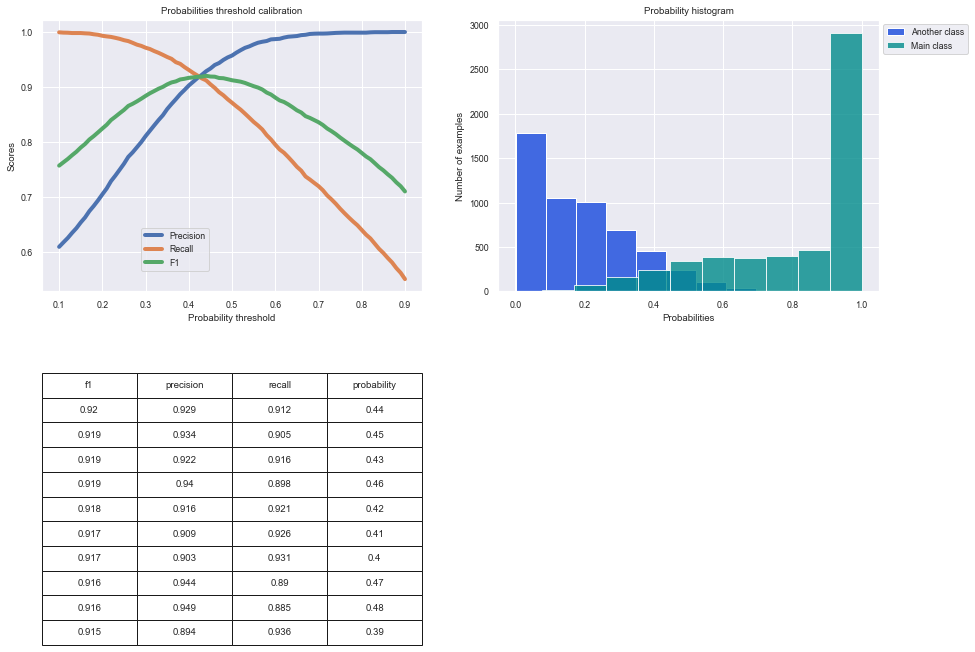

In [86]:
y_pred_probs = prod_model.predict_proba(train_data)
show_proba_calibration_plots(y_pred_probs[:, 1], y)

In [87]:
threshold = 0.44

In [88]:
y_pred_probs = prod_model.predict_proba(test_data)
submit_data = pd.DataFrame(np.where(y_pred_probs[:, 1] >= threshold, 1, 0), columns=(["Credit Default"])).reset_index().rename(columns={"index":"Id"})

In [89]:
# submit_data = prod_model.predict(test_data)
# submit_data = pd.DataFrame(submit_data, columns=(["Credit Default"])).reset_index().rename(columns={"index":"Id"})

In [90]:
submit_data.to_csv('gb_submit.csv', index=False)